*   Checkpoint: checkpoint_dpt_head_build.pt
*   mds txt: mds_normalization_stats_build.txt
*   Dataset: Goggle Satellite - 24
*   Batch Size: 3/3
*   Learning Rate: 10-4
*   Patience: 20

Loss: vggt_training_v12_build.ipynb

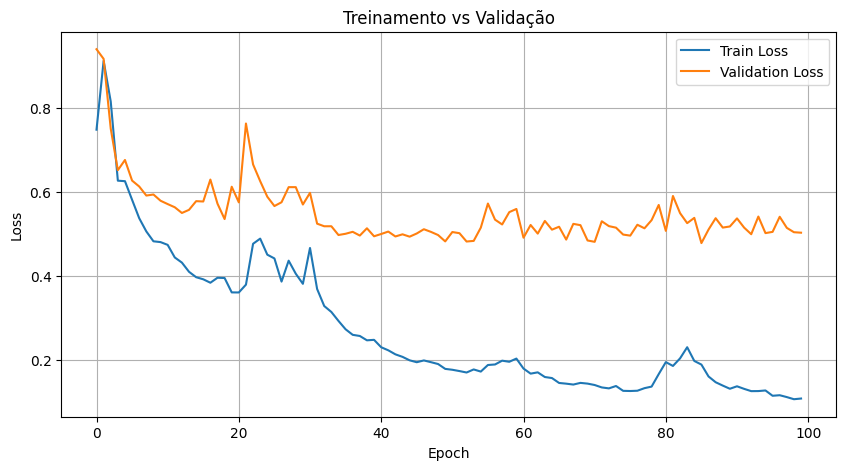

# VGGT Model

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change location to vggt folder
%cd "/content/drive/MyDrive/Colab Notebooks/vggt"

/content/drive/MyDrive/Colab Notebooks/vggt


In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 102.3 MB/s eta 0:00:00


In [6]:
# Import libraries
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import rasterio
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm # Import tqdm for progress bars
from vggt.models.vggt import VGGT
from vggt.utils.load_fn_tif_norm import load_and_preprocess_geotiff

## Env set up

## Training Data

In [42]:
train_input_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24"
train_reference_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24"

test_input_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24"
test_reference_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_reference_build_24"

In [43]:
# Check files sizes and number of bands
def get_tiff_info(folder_path):
    """
    Reads all GeoTIFF files in a folder and returns their names, dimensions,
    and number of bands.

    Args:
        folder_path (str): The path to the folder containing GeoTIFF files.

    Returns:
        list: A list of tuples, where each tuple contains the filename,
              its dimensions (height, width), and the number of bands.
    """
    tiff_info = []
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return tiff_info

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(".tif"):
            file_path = os.path.join(folder_path, file_name)
            try:
                with rasterio.open(file_path) as src:
                    tiff_info.append((file_name, (src.height, src.width), src.count))
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    return tiff_info

# Use the defined paths (assuming train_input_path, etc. are already defined)
train_input_info = get_tiff_info(train_input_path)
train_reference_info = get_tiff_info(train_reference_path)
test_input_info = get_tiff_info(test_input_path)
test_reference_info = get_tiff_info(test_reference_path)

print("Train Input TIFFs:")
for name, dims, bands in train_input_info:
    print(f"- {name}: {dims} (Bands: {bands})")

print("\nTrain Reference TIFFs:")
for name, dims, bands in train_reference_info:
    print(f"- {name}: {dims} (Bands: {bands})")

print("\nTest Input TIFFs:")
for name, dims, bands in test_input_info:
    print(f"- {name}: {dims} (Bands: {bands})")

print("\nTest Reference TIFFs:")
for name, dims, bands in test_reference_info:
    print(f"- {name}: {dims} (Bands: {bands})")

Train Input TIFFs:
- tile_2590_6734.tif: (518, 518) (Bands: 3)
- tile_2590_7252.tif: (518, 518) (Bands: 3)
- tile_4662_6216.tif: (518, 518) (Bands: 3)
- tile_4144_7252.tif: (518, 518) (Bands: 3)
- tile_3626_6734.tif: (518, 518) (Bands: 3)
- tile_3626_6216.tif: (518, 518) (Bands: 3)
- tile_2072_6734.tif: (518, 518) (Bands: 3)
- tile_2072_6216.tif: (518, 518) (Bands: 3)
- tile_1554_6734.tif: (518, 518) (Bands: 3)
- tile_1554_7770.tif: (518, 518) (Bands: 3)
- tile_1036_7770.tif: (518, 518) (Bands: 3)
- tile_518_2590.tif: (518, 518) (Bands: 3)
- tile_1036_7252.tif: (518, 518) (Bands: 3)
- tile_1554_7252.tif: (518, 518) (Bands: 3)
- tile_518_2072.tif: (518, 518) (Bands: 3)
- tile_518_1036.tif: (518, 518) (Bands: 3)
- tile_518_1554.tif: (518, 518) (Bands: 3)
- tile_5180_6216.tif: (518, 518) (Bands: 3)
- tile_5698_6734.tif: (518, 518) (Bands: 3)
- tile_5180_5698.tif: (518, 518) (Bands: 3)
- tile_5698_6216.tif: (518, 518) (Bands: 3)
- tile_6216_6734.tif: (518, 518) (Bands: 3)
- tile_5180_6734.

### Visualize training and test data

In [44]:
# # Visualize training input images
# print("\nVisualizing Training Input Images (First 10):") # Updated print message

# if not os.path.exists(train_input_path):
#     print(f"Folder not found: {train_input_path}")
# else:
#     image_count = 0 # Initialize a counter for images visualized
#     for file_name in os.listdir(train_input_path):
#         if file_name.lower().endswith(".tif"):
#             if image_count >= 10: # Check if we have already visualized 10 images
#                 print("Displayed 10 images. Stopping visualization.")
#                 break # Exit the loop if 10 images are shown

#             file_path = os.path.join(train_input_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Input: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Input: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                     elif src.count == 4:
#                         # Four-band image - assuming first 3 are RGB, display as RGB composite
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         # Select only the first 3 bands (index 0, 1, 2)
#                         rgb_composite = image_data[:3, :, :].transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_composite)
#                         plt.title(f"Input: {file_name} (RGB Composite)") # Updated title
#                         plt.show()
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")
#                         # Do not increment image_count as we are skipping visualization

#                 # Increment the counter only if an image was successfully processed for visualization
#                 if src.count in [1, 3, 4]:
#                      image_count += 1

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

In [45]:
# # Visualize training reference images
# print("\nVisualizing Training Reference Images:")

# if not os.path.exists(train_reference_path):
#     print(f"Folder not found: {train_reference_path}")
# else:
#     image_count = 0  # Initialize a counter for images visualized
#     for file_name in os.listdir(train_reference_path):
#         if file_name.lower().endswith(".tif"):
#             if image_count >= 10: # Check if we have already visualized 10 images
#                 print("Displayed 10 images. Stopping visualization.")
#                 break # Exit the loop if 10 images are shown

#             file_path = os.path.join(train_reference_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale, depth)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Reference: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                         image_count += 1 # Increment counter for successful visualization
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Reference: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                         image_count += 1 # Increment counter for successful visualization
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")
#                         # Do not increment image_count as we are skipping visualization

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

In [46]:
# # Visualize testing input images
# print("\nVisualizing Testing Input Images:")

# if not os.path.exists(train_input_path):
#     print(f"Folder not found: {test_input_path}")
# else:
#     for file_name in os.listdir(test_input_path):
#         if file_name.lower().endswith(".tif"):
#             file_path = os.path.join(test_input_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Input: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Input: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                     elif src.count == 4:
#                         # Four-band image - assuming first 3 are RGB, display as RGB composite
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         # Select only the first 3 bands (index 0, 1, 2)
#                         rgb_composite = image_data[:3, :, :].transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_composite)
#                         plt.title(f"Input: {file_name} (RGB Composite)") # Updated title
#                         plt.show()
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

In [47]:
# # Visualize testing reference images
# print("\nVisualizing Training Reference Images:")

# if not os.path.exists(test_reference_path):
#     print(f"Folder not found: {test_reference_path}")
# else:
#     for file_name in os.listdir(test_reference_path):
#         if file_name.lower().endswith(".tif"):
#             file_path = os.path.join(test_reference_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale, depth)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Reference: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Reference: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

## MDS Normalization

In [48]:
# Define image size, patch grid and patchcount
IMG_SIZE = (518, 518) # Valor original 518
PATCH_GRID = (37, 37)
PATCH_COUNT = PATCH_GRID[0] * PATCH_GRID[1]

In [49]:
# MDS normalization
def normalize_mds_zscore(mds_tensor):
    mean = mds_tensor.mean()
    std = mds_tensor.std()
    if std > 0:
        return (mds_tensor - mean) / std
    else:
        return mds_tensor * 0  # ou raise warning


In [50]:
# Assuming train_input_path and train_reference_path are already defined
image_list = glob.glob(os.path.join(train_input_path, "*.tif"))
mds_list = glob.glob(os.path.join(train_reference_path, "*.tif"))

# Optional: Sort the lists to ensure corresponding files are in the same order
image_list.sort()
mds_list.sort()

print(f"Found {len(image_list)} input images for training.")
print(f"Found {len(mds_list)} reference (MDS) images for training.")

Found 24 input images for training.
Found 24 reference (MDS) images for training.


In [51]:
# --- 2. Load ALL original MDS data to calculate global mean and std ---
# This might require significant memory if your dataset is large.
# For very large datasets, you might need an iterative approach (e.g., calculating sum and sum of squares in chunks)
all_mds_data_tensors = []
target_size = IMG_SIZE # Use your defined IMG_SIZE

print("Loading all training MDS data to calculate global mean and std...")
for mds_path in mds_list:
    try:
        # Load the original (unnormalized) data
        mds_tensor, _ = load_and_preprocess_geotiff([mds_path], mode="crop", target_size=target_size)

        if mds_tensor is None:
            print(f"Warning: Could not load {mds_path}. Skipping.")
            continue

        # Ensure the tensor shape and data type are consistent
        # load_and_preprocess_geotiff might return [B, C, H, W] or [C, H, W]
        # We want to treat each file as a 'batch' item temporarily if needed for concatenation
        if mds_tensor.dim() == 4 and mds_tensor.shape[0] == 1:
             mds_tensor = mds_tensor.squeeze(0) # Remove batch dim if it was added for single file
        elif mds_tensor.dim() != 3 or mds_tensor.shape[0] != 1:
             # Ensure it's [1, H, W] before appending
             if mds_tensor.shape[1:] == target_size and mds_tensor.dim() == 2: # Handle [H, W] case
                  mds_tensor = mds_tensor.unsqueeze(0) # Make it [1, H, W]
             else:
                  print(f"Warning: Unexpected MDS tensor shape for {mds_path}: {mds_tensor.shape}. Skipping.")
                  continue

        if mds_tensor.shape[1:] != target_size:
             print(f"Warning: MDS tensor for {mds_path} has incorrect spatial shape {mds_tensor.shape[1:]}. Expected {target_size}. Skipping.")
             continue


        all_mds_data_tensors.append(mds_tensor.to(torch.float32)) # Ensure consistent dtype

    except Exception as e:
        print(f"Error loading or processing {mds_path} for global stats: {e}")

if not all_mds_data_tensors:
     raise ValueError("No valid training MDS tensors were loaded to calculate global statistics.")

# Concatenate all tensors along a new dimension (or the existing batch dim if they are [1, H, W])
# If they are [1, H, W], concatenating along dim=0 results in [NumFiles, 1, H, W]
combined_mds_tensor = torch.cat(all_mds_data_tensors, dim=0)

Loading all training MDS data to calculate global mean and std...


In [52]:
# --- 3. Calculate the Global Mean and Standard Deviation ---
# Calculate mean and std across ALL files (treat the concatenated tensor as one large dataset)
# We want the mean and std of all pixel values across all images.
# Use .mean() and .std() without specifying dimensions to flatten the tensor conceptually.
global_train_mds_mean = combined_mds_tensor.mean()
global_train_mds_std = combined_mds_tensor.std()

print(f"\nGlobal Training MDS Mean: {global_train_mds_mean.item()}")
print(f"Global Training MDS Standard Deviation: {global_train_mds_std.item()}")


Global Training MDS Mean: 7.049096584320068
Global Training MDS Standard Deviation: 12.111794471740723


In [53]:
# Convert tensors to Python numbers for easy saving
mean_value = global_train_mds_mean.item()
std_value = global_train_mds_std.item()

# Define a file path to save the statistics
# It's good practice to save this alongside your trained model checkpoint
stats_file_path = 'mds_normalization_stats_build.txt'

try:
    with open(stats_file_path, 'w') as f:
        f.write(f'mean:{mean_value}\n')
        f.write(f'std:{std_value}\n')
    print(f"Global normalization statistics saved to {stats_file_path}")
except IOError as e:
    print(f"Error saving normalization statistics: {e}")

Global normalization statistics saved to mds_normalization_stats_build.txt


In [54]:
def normalize_mds_zscore_global(mds_tensor, global_mean, global_std):
    """
    Applies Z-score normalization using pre-calculated global mean and standard deviation.

    Args:
        mds_tensor (torch.Tensor): The input tensor to normalize.
        global_mean (float or torch.Tensor): The global mean of the training data.
        global_std (float or torch.Tensor): The global standard deviation of the training data.

    Returns:
        torch.Tensor: The normalized tensor.
    """
    if global_std is None or global_std <= 0:
        # Handle cases where std is zero or not provided
        # This might indicate a problem with the training data or a constant target
        print("Warning: Global standard deviation is zero or None. Returning tensor of zeros.")
        return torch.full_like(mds_tensor, 0.0)
    else:
        return (mds_tensor - global_mean) / global_std

In [55]:
class RemoteSensingHeightDataset(Dataset):
    def __init__(self, image_paths_list, mds_paths_list, global_mds_mean, global_mds_std, transform=None):
        self.image_paths = image_paths_list
        self.mds_paths = mds_paths_list
        self.global_mds_mean = global_mds_mean # Store the global mean
        self.global_mds_std = global_mds_std   # Store the global standard deviation
        self.transform = transform

        if len(self.image_paths) != len(self.mds_paths):
            raise ValueError("The number of image and MDS files do not match.")
        if not self.image_paths:
            raise ValueError("No image files found.")
        if not self.mds_paths:
            raise ValueError("No MDS files found.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mds_path = self.mds_paths[idx]

        try:
            image_tensor, _ = load_and_preprocess_geotiff([img_path], mode="crop", target_size=IMG_SIZE)
            mds_tensor, _ = load_and_preprocess_geotiff([mds_path], mode="crop", target_size=IMG_SIZE)
        except Exception as e:
            print(f"Error loading or preprocessing files: {img_path}, {mds_path}. Error: {e}")
            return None, None

        if image_tensor is None or mds_tensor is None:
            return None, None

        image_tensor = image_tensor.squeeze(0)

        if mds_tensor.dim() == 4:
            mds_tensor = mds_tensor.squeeze(0)

        if mds_tensor.dim() == 2:
            mds_tensor = mds_tensor.unsqueeze(0)
        elif mds_tensor.dim() != 3 or mds_tensor.shape[0] != 1:
            raise RuntimeError(f"Esperado MDS com shape [1, H, W], mas recebeu {mds_tensor.shape}. File: {mds_path}")

        if mds_tensor.shape[1:] != IMG_SIZE:
            raise RuntimeError(f"MDS com shape inesperado: esperado (1, {IMG_SIZE[0]}, {IMG_SIZE[1]}), mas recebeu {mds_tensor.shape}. File: {mds_path}")

        if image_tensor.shape[0] == 4:
            image_tensor = image_tensor[:3, :, :]
        elif image_tensor.shape[0] == 1:
            image_tensor = image_tensor.repeat(3, 1, 1)

        if image_tensor.shape[1:] != IMG_SIZE:
            raise RuntimeError(f"Image with incorrect shape after processing: expected (3, {IMG_SIZE[0]}, {IMG_SIZE[1]}), but received {image_tensor.shape}. File: {img_path}")

        # Conversão para float antes da normalização
        mds_tensor = mds_tensor.to(torch.float32)

        # Normalização Z-score
        mds_tensor = normalize_mds_zscore_global(mds_tensor, self.global_mds_mean, self.global_mds_std)

        image_tensor = image_tensor.to(torch.float32)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, mds_tensor


In [56]:
# Print Image List
image_list

['/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/t

In [57]:
# Print MDS List
mds_list

['/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_1036_7252.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_1036_7770.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_1554_6734.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_1554_7252.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_1554_7770.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_2072_6216.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_2072_6734.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_2590_6734.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_reference_build_24/tile_2590_7252.tif',
 '/content/drive/MyDrive/Colab Notebooks/vggt/

In [58]:
# --- Instantiate the Dataset with Normalization Parameters ---
# Ensure that the image and mds lists have the same length and corresponding files
if len(image_list) != len(mds_list):
    raise ValueError("The number of images and MDS files do not match. Please check your data.")

if not image_list:
    raise ValueError("No image files found.")
if not mds_list:
     raise ValueError("No MDS files found.")

print(f"Total image files found: {len(image_list)}")
print(f"Total MDS files found: {len(mds_list)}")
print(f"Total image-MDS pairs for the dataset: {len(image_list)}")

Total image files found: 24
Total MDS files found: 24
Total image-MDS pairs for the dataset: 24


## Training

In [59]:
# ## Visualize Training Progress
# # Function to visualize a batch's input, reference, and prediction
# def visualize_batch_results(input_images, reference_heights, predicted_heights, epoch, device, dtype):
#     """
#     Visualizes the first sample of a batch including the input image,
#     reference height map, and predicted height map.

#     Args:
#         input_images (torch.Tensor): The batch of input images.
#         reference_heights (torch.Tensor): The batch of reference height maps.
#         predicted_heights (torch.Tensor): The batch of predicted height maps.
#         epoch (int): The current epoch number for the title.
#         device (torch.device): The device tensors are on (e.g., 'cuda', 'cpu').
#         dtype (torch.dtype): The data type of the input images.
#     """
#     print(f"--- Visualizing results for Epoch {epoch} ---")

#     # Move tensors to CPU and convert to NumPy for visualization
#     # Select the first sample from the batch for visualization
#     # Ensure we are working with CPU tensors before converting to numpy
#     input_img_np = input_images[0].cpu().permute(1, 2, 0).numpy() # Permute to (H, W, C) for matplotlib
#     reference_height_np = reference_heights[0].squeeze(0).cpu().numpy() # Remove channel dim for single-band
#     predicted_height_np = predicted_heights[0].squeeze(0).cpu().numpy() # Remove channel dim for single-band

#     # Handle different channel counts for input image visualization
#     if input_img_np.shape[-1] == 1: # Grayscale input
#         input_img_np = input_img_np.squeeze(-1)
#         cmap_input = 'gray'
#     elif input_img_np.shape[-1] == 3: # RGB input
#          cmap_input = None # Use default matplotlib colormap for RGB
#     elif input_img_np.shape[-1] == 4: # RGBA input, display RGB
#          input_img_np = input_img_np[:, :, :3]
#          cmap_input = None
#     else:
#          print(f"Warning: Input image with {input_img_np.shape[-1]} bands, displaying as grayscale.")
#          input_img_np = input_img_np[:, :, 0] # Display the first band as grayscale
#          cmap_input = 'gray'

#     # Ensure the input image is in a plottable format (e.g., float in [0, 1] or uint8)
#     # Assuming input images might be normalized, clip to [0, 1] for display if they are float
#     if input_img_np.dtype == np.float32 or input_img_np.dtype == np.float64:
#         input_img_np = np.clip(input_img_np, 0, 1)
#     # If they are int, they should be in the expected range (e.g., 0-255)

#     # Visualize the input image, reference, and prediction
#     fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#     # Input Image
#     axes[0].imshow(input_img_np, cmap=cmap_input)
#     axes[0].set_title(f"Epoch {epoch} - Input Image")
#     axes[0].axis('off')

#     # Reference Height Map
#     im1 = axes[1].imshow(reference_height_np, cmap='viridis') # You can choose a different colormap for height
#     axes[1].set_title("Reference Height")
#     axes[1].axis('off')
#     fig.colorbar(im1, ax=axes[1], label='Height Value')

#     # Predicted Height Map
#     im2 = axes[2].imshow(predicted_height_np, cmap='viridis') # Use the same colormap as reference for comparison
#     axes[2].set_title("Predicted Height")
#     axes[2].axis('off')
#     fig.colorbar(im2, ax=axes[2], label='Height Value')

#     plt.tight_layout()
#     plt.show()

In [60]:
# def visualize_random_batch_sample(images, references, predictions, epoch=None, title_prefix="Treinamento"):
#     import matplotlib.pyplot as plt
#     import numpy as np
#     import random

#     idx = random.randint(0, images.shape[0] - 1)
#     print(f"[VIS] Visualizando amostra {idx} do batch")

#     image_np = images[idx].cpu().permute(1, 2, 0).numpy()
#     reference_np = references[idx].squeeze().cpu().numpy()
#     prediction_np = predictions[idx].squeeze().cpu().detach().numpy()

#     # Diagnóstico rápido
#     print("Input min/max:", image_np.min(), image_np.max())
#     print("Reference min/max:", reference_np.min(), reference_np.max())
#     print("Prediction min/max:", prediction_np.min(), prediction_np.max())

#     if image_np.dtype in [np.float3.2, np.float64]:
#         image_np = np.clip(image_np, 0, 1)

#     fig, axs = plt.subplots(1, 3, figsize=(14, 4))
#     if epoch is not None:
#         fig.suptitle(f"{title_prefix} - Época {epoch} - Amostra {idx}", fontsize=14)

#     axs[0].imshow(image_np)
#     axs[0].set_title("Imagem de Entrada")
#     axs[0].axis("off")

#     im1 = axs[1].imshow(reference_np, cmap="viridis")
#     axs[1].set_title("MDS de Referência")
#     axs[1].axis("off")
#     fig.colorbar(im1, ax=axs[1])

#     im2 = axs[2].imshow(prediction_np, cmap="viridis")
#     axs[2].set_title("Predição do Modelo")
#     axs[2].axis("off")
#     fig.colorbar(im2, ax=axs[2])

#     plt.tight_layout()
#     plt.show(block=True)
#     plt.close('all')


### Early Stopping

In [61]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### DPT Head

In [62]:
# # -----------------------------
# # TREINAMENTO COM DPTHead DO VGGT
# # -----------------------------
# import torch
# import torch.nn.functional as F
# from tqdm import tqdm
# import numpy as np # Ensure numpy is imported for EarlyStopping
# import os # Ensure os is imported for EarlyStopping path

# def train_dpt_head(
#     vggt_model,
#     dpt_head,
#     train_loader,
#     val_loader,
#     optimizer,
#     criterion,
#     num_epochs=10,
#     device="cuda",
#     dtype=torch.float32,
#     visualize_batches=False, # Changed default to False to avoid excessive plots
#     patience=20,  # Added patience for EarlyStopping
#     delta=0,     # Added delta for EarlyStopping
#     checkpoint_path='checkpoint_dpt_head.pt' # Added checkpoint path
# ):
#     vggt_model.eval()         # backbone congelado
#     dpt_head.train()          # head treinável

#     epoch_losses = []
#     val_losses = []

#     # Initialize Early Stopping
#     early_stopping = EarlyStopping(
#         patience=patience,
#         verbose=True,
#         delta=delta,
#         path=checkpoint_path
#     )

#     for epoch in range(num_epochs):
#         print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
#         running_loss = 0.0

#         # Training loop
#         for batch_idx, (images, target_heights) in enumerate(tqdm(train_loader)):
#             images = images.to(device, dtype=dtype)  # [B, 3, H, W]
#             target_heights = target_heights.to(device, dtype=torch.float32)  # [B, 1, H, W]

#             images_seq = images.unsqueeze(1)  # [B, S=1, C, H, W]

#             with torch.no_grad():
#                 tokens_list, patch_start_idx = vggt_model.aggregator(images_seq)

#             preds, _ = dpt_head(tokens_list, images_seq, patch_start_idx)  # [B, S, 1, H, W]
#             preds = preds[:, 0]  # Seleciona S=0 => [B, 1, H, W]

#             # Verifica se as dimensões são válidas
#             if preds.shape[-1] == 0 or preds.shape[-2] == 0:
#                 print(f"[ERRO] Predição com shape inválido: {preds.shape} — ignorando batch {batch_idx}")
#                 continue

#             if preds.shape != target_heights.shape:
#                 preds = F.interpolate(preds, size=target_heights.shape[-2:], mode="bilinear", align_corners=True)

#             # Ensure preds is float3.2 for loss calculation
#             preds = preds.to(torch.float32)

#             loss = criterion(preds, target_heights)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             if batch_idx % 10 == 0: # Print loss every 10 batches
#                  tqdm.write(f"  Batch {batch_idx+1}: loss = {loss.item():.4f}")

#             if visualize_batches and batch_idx % 50 == 0: # Visualize every 50 batches if enabled
#                 visualize_random_batch_sample(images.detach().cpu(), target_heights.detach().cpu(), preds.detach().cpu(), epoch=epoch+1)


#         avg_loss = running_loss / len(train_loader)
#         epoch_losses.append(avg_loss)
#         print(f"[Epoch {epoch+1}] Train Loss (avg): {avg_loss:.4f}")



#         # --- Validation ---
#         dpt_head.eval()
#         val_loss_total = 0.0
#         with torch.no_grad():
#             for val_rgb, val_mds in val_loader:
#                 val_rgb = val_rgb.to(device, dtype=dtype)
#                 val_mds = val_mds.to(device, dtype=torch.float32) # Changed to float3.2

#                 val_seq = val_rgb.unsqueeze(1)
#                 val_tokens, patch_start_idx = vggt_model.aggregator(val_seq)
#                 val_preds, _ = dpt_head(val_tokens, val_seq, patch_start_idx)

#                 val_preds = val_preds[:, 0]
#                 # if val_preds.shape != val_mds.shape:
#                 #     val_preds = F.interpolate(val_preds, size=val_mds.shape[-2:], mode="bilinear", align_corners=True)
#                 # if visualize_batches: # Can optionally visualize validation batches too
#                 #     visualize_random_batch_sample(val_rgb.detach().cpu(), val_mds.detach().cpu(), val_preds.detach().cpu(), epoch=epoch+1, title_prefix="Validação")


#                 # Ensure val_preds is float3.2 for loss calculation
#                 val_preds = val_preds.to(torch.float32)

#                 loss_val = criterion(val_preds, val_mds)
#                 val_loss_total += loss_val.item()

#         val_avg = val_loss_total / len(val_loader)
#         val_losses.append(val_avg)
#         print(f"[Epoch {epoch+1}] Val Loss: {val_avg:.4f}")

#         # --- Early Stopping Check ---
#         early_stopping(val_avg, dpt_head) # Pass validation loss and the model to EarlyStopping

#         if early_stopping.early_stop:
#             print("Early stopping triggered.")
#             break # Exit the main epoch loop

#         dpt_head.train() # Set back to training mode after validation


#     # Load the best model weights
#     if os.path.exists(checkpoint_path):
#         print(f"Loading best model from {checkpoint_path}")
#         dpt_head.load_state_dict(torch.load(checkpoint_path))
#     else:
#         print(f"Warning: Checkpoint file not found at {checkpoint_path}. Returning the model from the last epoch.")


#     return epoch_losses, val_losses

In [63]:
def train_dpt_head(
    vggt_model,
    dpt_head,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs=10,
    device="cuda",
    dtype=torch.float32,
    visualize_batches=False,
    patience=20,
    delta=0,
    checkpoint_path='checkpoint_dpt_head_build.pt'
):
    vggt_model.eval()
    dpt_head.train()

    epoch_losses = []
    val_losses = []

    # Lists to store loss for each batch
    train_batch_losses = []
    val_batch_losses = []


    early_stopping = EarlyStopping(
        patience=patience,
        verbose=True,
        delta=delta,
        path=checkpoint_path
    )

    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        running_loss = 0.0
        # Reset batch losses for the new epoch
        epoch_train_batch_losses = []
        epoch_val_batch_losses = []


        # Training loop
        for batch_idx, (images, target_heights) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
            images = images.to(device, dtype=dtype)
            target_heights = target_heights.to(device, dtype=torch.float32)

            images_seq = images.unsqueeze(1)

            with torch.no_grad():
                tokens_list, patch_start_idx = vggt_model.aggregator(images_seq)

            preds, _ = dpt_head(tokens_list, images_seq, patch_start_idx)
            preds = preds[:, 0]

            if preds.shape[-1] == 0 or preds.shape[-2] == 0:
                tqdm.write(f"[ERRO] Predição com shape inválido: {preds.shape} — ignorando batch {batch_idx}")
                continue

            if preds.shape != target_heights.shape:
                preds = F.interpolate(preds, size=target_heights.shape[-2:], mode="bilinear", align_corners=True)

            preds = preds.to(torch.float32)

            loss = criterion(preds, target_heights)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Store or print loss for this training batch
            epoch_train_batch_losses.append(loss.item())
            tqdm.write(f"  Epoch {epoch+1} Train Batch {batch_idx+1}: loss = {loss.item():.4f}")


            if visualize_batches and batch_idx % 50 == 0:
                # Assuming visualize_random_batch_sample is defined
                # visualize_random_batch_sample(images.detach().cpu(), target_heights.detach().cpu(), preds.detach().cpu(), epoch=epoch+1)
                pass # Add visualization call if the function is available


        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        train_batch_losses.append(epoch_train_batch_losses) # Store all batch losses for this epoch
        print(f"[Epoch {epoch+1}] Train Loss (avg): {avg_loss:.4f}")


        # --- Validation ---
        dpt_head.eval()
        val_loss_total = 0.0
        # Reset validation batch losses for the new epoch
        epoch_val_batch_losses = []

        with torch.no_grad():
            for batch_idx, (val_rgb, val_mds) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")):
                val_rgb = val_rgb.to(device, dtype=dtype)
                val_mds = val_mds.to(device, dtype=torch.float32)

                val_seq = val_rgb.unsqueeze(1)
                val_tokens, patch_start_idx = vggt_model.aggregator(val_seq)
                val_preds, _ = dpt_head(val_tokens, val_seq, patch_start_idx)

                val_preds = val_preds[:, 0]
                # if val_preds.shape != val_mds.shape:
                #     val_preds = F.interpolate(val_preds, size=val_mds.shape[-2:], mode="bilinear", align_corners=True)
                # if visualize_batches:
                #     visualize_random_batch_sample(val_rgb.detach().cpu(), val_mds.detach().cpu(), val_preds.detach().cpu(), epoch=epoch+1, title_prefix="Validação")


                val_preds = val_preds.to(torch.float32)

                loss_val = criterion(val_preds, val_mds)
                val_loss_total += loss_val.item()
                # Store or print loss for this validation batch
                epoch_val_batch_losses.append(loss_val.item())
                tqdm.write(f"  Epoch {epoch+1} Val Batch {batch_idx+1}: loss = {loss_val.item():.4f}")


        val_avg = val_loss_total / len(val_loader)
        val_losses.append(val_avg)
        val_batch_losses.append(epoch_val_batch_losses) # Store all batch losses for this epoch
        print(f"[Epoch {epoch+1}] Val Loss: {val_avg:.4f}")


        # --- Early Stopping Check ---
        early_stopping(val_avg, dpt_head)

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        dpt_head.train()


    # Load the best model weights
    if os.path.exists(checkpoint_path):
        print(f"Loading best model from {checkpoint_path}")
        dpt_head.load_state_dict(torch.load(checkpoint_path))
    else:
        print(f"Warning: Checkpoint file not found at {checkpoint_path}. Returning the model from the last epoch.")


    # Return batch losses along with epoch losses
    return epoch_losses, val_losses, train_batch_losses, val_batch_losses

In [64]:
# Define o dispositivo a ser usado (GPU se disponível, CPU caso contrário)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define o tipo de dado a ser usado para o modelo e os tensores
# Geralmente torch.float3.2 é o padrão, mas float1.6 ou bfloat1.6 podem ser usados para economizar memória na GPU
dtype = torch.float32 # ou torch.float1.6, torch.bfloat1.6 dependendo da sua necessidade e hardware

print(f"Usando dispositivo: {device}, DTYPE: {dtype}")

print("Carregando modelo VGGT pré-treinado...")
# O VGGT será carregado no CPU primeiro, depois movido para DEVICE
vggt_model = VGGT.from_pretrained("facebook/VGGT-1B")

# Add this line to clear potential residual memory before moving the model
import gc
# Check if 'images' is defined in the global scope before attempting to delete
if 'images' in globals():
    del images # Delete images tensor if it's still in memory from prediction step
if 'depth_map' in globals(): # Delete depth_map if it exists
    del depth_map
if 'depth_map_np' in globals(): # Delete depth_map_np if it exists
    del depth_map_np
gc.collect() # Explicitly call garbage collector
if torch.cuda.is_available():
    torch.cuda.empty_cache() # Clear CUDA cache


vggt_model = vggt_model.to(device)
# O DTYPE do modelo VGGT é definido internamente ou pela forma como é carregado.
# Se DTYPE é float1.6 ou bfloat1.6, aplicar .to(dtype=DTYPE) pode ser necessário se não for automático.
# A linha `images = images.to(DEVICE, dtype=DTYPE)` já cuida da entrada.
# vggt_model.to(dtype=DTYPE) # Pode ser redundante se from_pretrained já lida com isso ou se DTYPE for float3.2
if dtype != torch.float32: # Aplicar DTYPE ao modelo se não for float3.2 padrão
    print(f"Convertendo modelo VGGT para {dtype}...")
    vggt_model = vggt_model.to(dtype=dtype)


for p in vggt_model.parameters():
    p.requires_grad = False # Congela todos os parâmetros do VGGT

# O embed_dim do VGGT-1B, conforme o erro, é 2048 na saída que usamos.
# O print do modelo na pergunta original mostrava dimensão interna de 1024,
# mas o "Shape completo" dos embeddings era [4, 1, 1374, 2048].
# Então, o `embed_dim` para a HeightHead deve ser 2048.
vggt_embed_dim = 2048
print(f"Inicializando head de altura com embed_dim={vggt_embed_dim}...")

Usando dispositivo: cuda, DTYPE: torch.float32
Carregando modelo VGGT pré-treinado...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

Inicializando head de altura com embed_dim=2048...


In [65]:
from vggt.heads.dpt_head import DPTHead

dpt_head = DPTHead(
    dim_in=2048,
    patch_size=14,
    output_dim=2,  # ou 4 se quiser também confiança e coordenadas
    activation="inv_log",
    conf_activation="expp1",
    features=256,
    out_channels=[256, 512, 1024, 1024],
    intermediate_layer_idx=[4, 11, 17, 23],
    pos_embed=True,
    feature_only=False,
    down_ratio=1
).to(device)

if dtype != torch.float32:
    print(f"Convertendo DPTHead para {dtype}...")
    dpt_head = dpt_head.to(dtype=dtype)

In [66]:
# --- CAMINHOS PARA OS DADOS ---

print("Listando arquivos de entrada...")
image_list = sorted([os.path.join(train_input_path, f) for f in os.listdir(train_input_path) if f.endswith(".tif") or f.endswith(".tiff")])
mds_list = sorted([os.path.join(train_reference_path, f) for f in os.listdir(train_reference_path) if f.endswith(".tif") or f.endswith(".tiff")])

# Correcting dataset initialization to use the generated lists
# Instantiate the dataset, passing the global stats
dataset = RemoteSensingHeightDataset(
    image_list,
    mds_list,
    global_mds_mean=global_train_mds_mean.item(), # Pass as Python numbers or tensors, be consistent
    global_mds_std=global_train_mds_std.item()
)

Listando arquivos de entrada...


In [67]:
# Garantir que as listas de imagens e mds correspondem (mesmo nome de arquivo, por exemplo)
# Esta é uma verificação simples. Uma correspondência mais robusta pode ser necessária.
if len(image_list) != len(mds_list):
    print(f"Aviso: Número de imagens ({len(image_list)}) é diferente do número de MDS ({len(mds_list)}). Verifique os arquivos.")
    # Decide como lidar: erro ou tentar parear. Por enquanto, prossegue se não for zero.

if not image_list:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_input_path}")
if not mds_list:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_reference_path}")

print(f"Total de arquivos de imagem encontrados: {len(image_list)}")
print(f"Total de arquivos MDS encontrados: {len(mds_list)}")


if len(image_list) != len(mds_list):
      raise ValueError("O número de imagens e arquivos MDS não coincidem após o pareamento ou as listas têm tamanhos diferentes. Verifique seus dados.")
if not image_list:
      raise ValueError("Nenhum par imagem-MDS correspondente encontrado.")


print(f"Total de pares imagem-MDS para o dataset de treinamento: {len(image_list)}")

Total de arquivos de imagem encontrados: 24
Total de arquivos MDS encontrados: 24
Total de pares imagem-MDS para o dataset de treinamento: 24


In [68]:
# Define DataLoader
batch_size_data_loader = 3
dataloader = DataLoader(dataset, batch_size=batch_size_data_loader, shuffle=True, num_workers=0)

# Define Optimizer (corrigido para dpt_head)
learning_rate = 1e-4
optimizer = torch.optim.Adam(dpt_head.parameters(), lr=learning_rate)

In [69]:
# Pegando uma imagem e MDS do dataset para teste manual
images, _ = dataset[0]  # apenas a imagem, ignora o MDS

images = images.unsqueeze(0).to(device)  # [B=1, 3, H, W]
images_seq = images.unsqueeze(1)         # [B=1, S=1, 3, H, W]

tokens_list, patch_start_idx = vggt_model.aggregator(images_seq)
preds, conf = dpt_head(tokens_list, images_seq, patch_start_idx)

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


In [70]:
# Prepare os inputs com os tokens do VGGT
images_seq = images.unsqueeze(1)
tokens_list, patch_start_idx = vggt_model.aggregator(images_seq)

preds, conf = dpt_head(tokens_list, images_seq, patch_start_idx)

In [71]:
print("Listando arquivos de entrada...")
image_list_test = sorted([os.path.join(test_input_path, f) for f in os.listdir(test_input_path) if f.endswith(".tif") or f.endswith(".tiff")])
mds_list_test = sorted([os.path.join(test_reference_path, f) for f in os.listdir(test_reference_path) if f.endswith(".tif") or f.endswith(".tiff")])

# Validation dataset
batch_size_test = 3
val_dataset = RemoteSensingHeightDataset(image_list_test, mds_list_test, global_mds_mean=global_train_mds_mean.item(), global_mds_std=global_train_mds_std.item())
val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=False)

Listando arquivos de entrada...


In [72]:
# Garantir que as listas de imagens e mds correspondem (mesmo nome de arquivo, por exemplo)
# Esta é uma verificação simples. Uma correspondência mais robusta pode ser necessária.
if len(image_list_test) != len(mds_list_test):
    print(f"Aviso: Número de imagens ({len(image_list_test)}) é diferente do número de MDS ({len(mds_list_test)}). Verifique os arquivos.")
    # Decide como lidar: erro ou tentar parear. Por enquanto, prossegue se não for zero.

if not image_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_input_path}")
if not mds_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_reference_path}")

print(f"Total de arquivos de imagem encontrados: {len(image_list_test)}")
print(f"Total de arquivos MDS encontrados: {len(mds_list_test)}")


if len(image_list_test) != len(mds_list_test):
      raise ValueError("O número de imagens e arquivos MDS não coincidem após o pareamento ou as listas têm tamanhos diferentes. Verifique seus dados.")
if not image_list_test:
      raise ValueError("Nenhum par imagem-MDS correspondente encontrado.")


print(f"Total de pares imagem-MDS para o dataset de treinamento: {len(image_list_test)}")

Total de arquivos de imagem encontrados: 6
Total de arquivos MDS encontrados: 6
Total de pares imagem-MDS para o dataset de treinamento: 6


In [73]:
# Garantir que as listas de imagens e mds correspondem (mesmo nome de arquivo, por exemplo)
# Esta é uma verificação simples. Uma correspondência mais robusta pode ser necessária.
if len(image_list_test) != len(mds_list_test):
    print(f"Aviso: Número de imagens ({len(image_list_test)}) é diferente do número de MDS ({len(mds_list_test)}). Verifique os arquivos de teste.")
    # Decide como lidar: erro ou tentar parear. Por enquanto, prossegue se não for zero.

if not image_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_input_path}")
if not mds_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_reference_path}")

print(f"Total de arquivos de imagem encontrados: {len(image_list_test)}")
print(f"Total de arquivos MDS encontrados: {len(mds_list_test)}")


if len(image_list_test) != len(mds_list_test):
      raise ValueError("O número de imagens e arquivos MDS não coincidem após o pareamento ou as listas têm tamanhos diferentes. Verifique seus dados de teste.")
if not image_list_test:
      raise ValueError("Nenhum par imagem-MDS correspondente encontrado.")


print(f"Total de pares imagem-MDS para o dataset de teste: {len(image_list_test)}")

Total de arquivos de imagem encontrados: 6
Total de arquivos MDS encontrados: 6
Total de pares imagem-MDS para o dataset de teste: 6


In [74]:
# Add this line to clear potential residual memory before moving the model
import gc
# Check if 'images' is defined in the global scope before attempting to delete
if 'images' in globals():
    del images # Delete images tensor if it's still in memory from prediction step
if 'depth_map' in globals(): # Delete depth_map if it exists
    del depth_map
if 'depth_map_np' in globals(): # Delete depth_map_np if it exists
    del depth_map_np
gc.collect() # Explicitly call garbage collector
if torch.cuda.is_available():
    torch.cuda.empty_cache() # Clear CUDA cache

In [75]:
print("Iniciando treinamento...")

total_epochs = 100
# Unpack into four variables
epoch_losses, val_losses, train_batch_losses, val_batch_losses = train_dpt_head(
    vggt_model=vggt_model,
    dpt_head=dpt_head,
    train_loader=dataloader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=torch.nn.MSELoss(),
    num_epochs=total_epochs,
    device=device,
    dtype=dtype
)

print("Treinamento finalizado.")

Iniciando treinamento...

--- Epoch 1/100 ---


Epoch 1 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training:  12%|█▎        | 1/8 [00:04<00:34,  4.95s/it]

  Epoch 1 Train Batch 1: loss = 0.8263
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training:  25%|██▌       | 2/8 [00:09<00:28,  4.68s/it]

  Epoch 1 Train Batch 2: loss = 0.8013
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training:  38%|███▊      | 3/8 [00:14<00:25,  5.05s/it]

  Epoch 1 Train Batch 3: loss = 1.1128
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training:  50%|█████     | 4/8 [00:29<00:35,  8.78s/it]

  Epoch 1 Train Batch 4: loss = 1.2145
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training:  62%|██████▎   | 5/8 [00:34<00:21,  7.26s/it]

  Epoch 1 Train Batch 5: loss = 0.8771
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training:  75%|███████▌  | 6/8 [00:38<00:12,  6.20s/it]

  Epoch 1 Train Batch 6: loss = 1.0498
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training:  88%|████████▊ | 7/8 [00:43<00:05,  5.77s/it]

  Epoch 1 Train Batch 7: loss = 1.1025
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Training: 100%|██████████| 8/8 [00:47<00:00,  5.95s/it]


  Epoch 1 Train Batch 8: loss = 1.1028
[Epoch 1] Train Loss (avg): 1.0109


Epoch 1 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Validation:  50%|█████     | 1/2 [00:05<00:05,  5.65s/it]

  Epoch 1 Val Batch 1: loss = 0.5719
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 1 Validation: 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


  Epoch 1 Val Batch 2: loss = 1.1933
[Epoch 1] Val Loss: 0.8826
Validation loss decreased (inf --> 0.882627).  Saving model ...

--- Epoch 2/100 ---


Epoch 2 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training:  12%|█▎        | 1/8 [00:03<00:24,  3.54s/it]

  Epoch 2 Train Batch 1: loss = 0.7508
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training:  25%|██▌       | 2/8 [00:07<00:20,  3.49s/it]

  Epoch 2 Train Batch 2: loss = 0.9739
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training:  38%|███▊      | 3/8 [00:10<00:17,  3.48s/it]

  Epoch 2 Train Batch 3: loss = 0.7729
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training:  50%|█████     | 4/8 [00:14<00:14,  3.52s/it]

  Epoch 2 Train Batch 4: loss = 1.2328
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training:  62%|██████▎   | 5/8 [00:17<00:10,  3.51s/it]

  Epoch 2 Train Batch 5: loss = 1.2020
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.93s/it]

  Epoch 2 Train Batch 6: loss = 0.8242
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training:  88%|████████▊ | 7/8 [00:25<00:03,  3.81s/it]

  Epoch 2 Train Batch 7: loss = 1.2095
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Training: 100%|██████████| 8/8 [00:29<00:00,  3.68s/it]


  Epoch 2 Train Batch 8: loss = 0.9573
[Epoch 2] Train Loss (avg): 0.9904


Epoch 2 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.18s/it]

  Epoch 2 Val Batch 1: loss = 0.5476
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 2 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


  Epoch 2 Val Batch 2: loss = 1.1625
[Epoch 2] Val Loss: 0.8550
Validation loss decreased (0.882627 --> 0.855025).  Saving model ...

--- Epoch 3/100 ---


Epoch 3 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training:  12%|█▎        | 1/8 [00:03<00:25,  3.62s/it]

  Epoch 3 Train Batch 1: loss = 0.8155
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training:  25%|██▌       | 2/8 [00:07<00:21,  3.59s/it]

  Epoch 3 Train Batch 2: loss = 0.9993
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training:  38%|███▊      | 3/8 [00:10<00:17,  3.59s/it]

  Epoch 3 Train Batch 3: loss = 0.9002
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training:  50%|█████     | 4/8 [00:17<00:19,  4.86s/it]

  Epoch 3 Train Batch 4: loss = 1.1987
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.41s/it]

  Epoch 3 Train Batch 5: loss = 1.2920
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.14s/it]

  Epoch 3 Train Batch 6: loss = 0.9430
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.98s/it]

  Epoch 3 Train Batch 7: loss = 0.5772
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Training: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]


  Epoch 3 Train Batch 8: loss = 0.8219
[Epoch 3] Train Loss (avg): 0.9435


Epoch 3 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.28s/it]

  Epoch 3 Val Batch 1: loss = 0.5119
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 3 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.29s/it]


  Epoch 3 Val Batch 2: loss = 1.0555
[Epoch 3] Val Loss: 0.7837
Validation loss decreased (0.855025 --> 0.783709).  Saving model ...

--- Epoch 4/100 ---


Epoch 4 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.78s/it]

  Epoch 4 Train Batch 1: loss = 0.6202
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 4 Train Batch 2: loss = 0.6500
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 4 Train Batch 3: loss = 1.2177
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training:  50%|█████     | 4/8 [00:17<00:19,  4.77s/it]

  Epoch 4 Train Batch 4: loss = 1.0020
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.40s/it]

  Epoch 4 Train Batch 5: loss = 0.7592
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training:  75%|███████▌  | 6/8 [00:25<00:08,  4.18s/it]

  Epoch 4 Train Batch 6: loss = 1.1320
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.04s/it]

  Epoch 4 Train Batch 7: loss = 0.8592
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Training: 100%|██████████| 8/8 [00:32<00:00,  4.08s/it]


  Epoch 4 Train Batch 8: loss = 1.0239
[Epoch 4] Train Loss (avg): 0.9080


Epoch 4 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 4 Val Batch 1: loss = 0.4918
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 4 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 4 Val Batch 2: loss = 1.0217
[Epoch 4] Val Loss: 0.7568
Validation loss decreased (0.783709 --> 0.756773).  Saving model ...

--- Epoch 5/100 ---


Epoch 5 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.79s/it]

  Epoch 5 Train Batch 1: loss = 0.7312
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 5 Train Batch 2: loss = 0.7679
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 5 Train Batch 3: loss = 1.1902
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training:  50%|█████     | 4/8 [00:17<00:18,  4.74s/it]

  Epoch 5 Train Batch 4: loss = 1.0585
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.37s/it]

  Epoch 5 Train Batch 5: loss = 0.7070
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.14s/it]

  Epoch 5 Train Batch 6: loss = 0.6673
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.99s/it]

  Epoch 5 Train Batch 7: loss = 0.7317
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Training: 100%|██████████| 8/8 [00:32<00:00,  4.04s/it]


  Epoch 5 Train Batch 8: loss = 0.7347
[Epoch 5] Train Loss (avg): 0.8236


Epoch 5 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it]

  Epoch 5 Val Batch 1: loss = 0.4435
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 5 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


  Epoch 5 Val Batch 2: loss = 0.8911
[Epoch 5] Val Loss: 0.6673
Validation loss decreased (0.756773 --> 0.667266).  Saving model ...

--- Epoch 6/100 ---


Epoch 6 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.75s/it]

  Epoch 6 Train Batch 1: loss = 0.7172
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.72s/it]

  Epoch 6 Train Batch 2: loss = 1.0380
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.71s/it]

  Epoch 6 Train Batch 3: loss = 0.7964
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training:  50%|█████     | 4/8 [00:17<00:18,  4.62s/it]

  Epoch 6 Train Batch 4: loss = 0.8498
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.30s/it]

  Epoch 6 Train Batch 5: loss = 0.7759
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.11s/it]

  Epoch 6 Train Batch 6: loss = 0.5724
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.99s/it]

  Epoch 6 Train Batch 7: loss = 0.5896
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Training: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]


  Epoch 6 Train Batch 8: loss = 0.5331
[Epoch 6] Train Loss (avg): 0.7340


Epoch 6 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 6 Val Batch 1: loss = 0.4105
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 6 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 6 Val Batch 2: loss = 0.9531
[Epoch 6] Val Loss: 0.6818
EarlyStopping counter: 1 of 20

--- Epoch 7/100 ---


Epoch 7 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.75s/it]

  Epoch 7 Train Batch 1: loss = 0.5779
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 7 Train Batch 2: loss = 0.7648
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 7 Train Batch 3: loss = 0.8099
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 7 Train Batch 4: loss = 0.5911
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 7 Train Batch 5: loss = 0.6458
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 7 Train Batch 6: loss = 0.8002
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 7 Train Batch 7: loss = 0.6288
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 7 Train Batch 8: loss = 0.7992
[Epoch 7] Train Loss (avg): 0.7022


Epoch 7 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 7 Val Batch 1: loss = 0.3648
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 7 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


  Epoch 7 Val Batch 2: loss = 0.8782
[Epoch 7] Val Loss: 0.6215
Validation loss decreased (0.667266 --> 0.621501).  Saving model ...

--- Epoch 8/100 ---


Epoch 8 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training:  12%|█▎        | 1/8 [00:03<00:25,  3.71s/it]

  Epoch 8 Train Batch 1: loss = 0.9915
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 8 Train Batch 2: loss = 0.4843
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 8 Train Batch 3: loss = 0.6746
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training:  50%|█████     | 4/8 [00:16<00:17,  4.42s/it]

  Epoch 8 Train Batch 4: loss = 0.6288
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.21s/it]

  Epoch 8 Train Batch 5: loss = 0.7157
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.05s/it]

  Epoch 8 Train Batch 6: loss = 0.4815
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training:  88%|████████▊ | 7/8 [00:27<00:03,  3.94s/it]

  Epoch 8 Train Batch 7: loss = 0.5972
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Training: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]


  Epoch 8 Train Batch 8: loss = 0.5039
[Epoch 8] Train Loss (avg): 0.6347


Epoch 8 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 8 Val Batch 1: loss = 0.3563
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 8 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 8 Val Batch 2: loss = 0.8142
[Epoch 8] Val Loss: 0.5853
Validation loss decreased (0.621501 --> 0.585265).  Saving model ...

--- Epoch 9/100 ---


Epoch 9 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 9 Train Batch 1: loss = 0.6988
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 9 Train Batch 2: loss = 0.5550
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 9 Train Batch 3: loss = 0.5085
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training:  50%|█████     | 4/8 [00:16<00:18,  4.54s/it]

  Epoch 9 Train Batch 4: loss = 0.8582
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.25s/it]

  Epoch 9 Train Batch 5: loss = 0.4904
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.07s/it]

  Epoch 9 Train Batch 6: loss = 0.5035
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.95s/it]

  Epoch 9 Train Batch 7: loss = 0.6239
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Training: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


  Epoch 9 Train Batch 8: loss = 0.7008
[Epoch 9] Train Loss (avg): 0.6174


Epoch 9 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 9 Val Batch 1: loss = 0.3994
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 9 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 9 Val Batch 2: loss = 0.7018
[Epoch 9] Val Loss: 0.5506
Validation loss decreased (0.585265 --> 0.550648).  Saving model ...

--- Epoch 10/100 ---


Epoch 10 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 10 Train Batch 1: loss = 0.3876
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.72s/it]

  Epoch 10 Train Batch 2: loss = 0.8604
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 10 Train Batch 3: loss = 0.4600
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training:  50%|█████     | 4/8 [00:17<00:18,  4.57s/it]

  Epoch 10 Train Batch 4: loss = 0.6288
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.27s/it]

  Epoch 10 Train Batch 5: loss = 0.4606
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.11s/it]

  Epoch 10 Train Batch 6: loss = 0.5074
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.98s/it]

  Epoch 10 Train Batch 7: loss = 0.6023
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Training: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]


  Epoch 10 Train Batch 8: loss = 0.6543
[Epoch 10] Train Loss (avg): 0.5702


Epoch 10 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 10 Val Batch 1: loss = 0.3385
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 10 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 10 Val Batch 2: loss = 0.6759
[Epoch 10] Val Loss: 0.5072
Validation loss decreased (0.550648 --> 0.507240).  Saving model ...

--- Epoch 11/100 ---


Epoch 11 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training:  12%|█▎        | 1/8 [00:03<00:25,  3.71s/it]

  Epoch 11 Train Batch 1: loss = 0.4807
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 11 Train Batch 2: loss = 0.6601
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 11 Train Batch 3: loss = 0.6280
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training:  50%|█████     | 4/8 [00:16<00:18,  4.53s/it]

  Epoch 11 Train Batch 4: loss = 0.5246
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.25s/it]

  Epoch 11 Train Batch 5: loss = 0.3856
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.09s/it]

  Epoch 11 Train Batch 6: loss = 0.5269
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.97s/it]

  Epoch 11 Train Batch 7: loss = 0.3699
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Training: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]


  Epoch 11 Train Batch 8: loss = 0.6851
[Epoch 11] Train Loss (avg): 0.5326


Epoch 11 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 11 Val Batch 1: loss = 0.3442
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 11 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 11 Val Batch 2: loss = 0.6583
[Epoch 11] Val Loss: 0.5013
Validation loss decreased (0.507240 --> 0.501252).  Saving model ...

--- Epoch 12/100 ---


Epoch 12 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.72s/it]

  Epoch 12 Train Batch 1: loss = 0.5232
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 12 Train Batch 2: loss = 0.3749
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 12 Train Batch 3: loss = 0.5281
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training:  50%|█████     | 4/8 [00:17<00:18,  4.57s/it]

  Epoch 12 Train Batch 4: loss = 0.5360
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.26s/it]

  Epoch 12 Train Batch 5: loss = 0.5033
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.10s/it]

  Epoch 12 Train Batch 6: loss = 0.7867
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.98s/it]

  Epoch 12 Train Batch 7: loss = 0.5587
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Training: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]


  Epoch 12 Train Batch 8: loss = 0.5707
[Epoch 12] Train Loss (avg): 0.5477


Epoch 12 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 12 Val Batch 1: loss = 0.4768
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 12 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 12 Val Batch 2: loss = 0.6835
[Epoch 12] Val Loss: 0.5802
EarlyStopping counter: 1 of 20

--- Epoch 13/100 ---


Epoch 13 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 13 Train Batch 1: loss = 0.7075
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 13 Train Batch 2: loss = 0.4529
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 13 Train Batch 3: loss = 0.5249
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 13 Train Batch 4: loss = 0.4392
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 13 Train Batch 5: loss = 0.4345
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 13 Train Batch 6: loss = 0.4922
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 13 Train Batch 7: loss = 0.5472
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 13 Train Batch 8: loss = 0.5455
[Epoch 13] Train Loss (avg): 0.5180


Epoch 13 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.34s/it]

  Epoch 13 Val Batch 1: loss = 0.3196
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 13 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 13 Val Batch 2: loss = 0.6468
[Epoch 13] Val Loss: 0.4832
Validation loss decreased (0.501252 --> 0.483169).  Saving model ...

--- Epoch 14/100 ---


Epoch 14 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.72s/it]

  Epoch 14 Train Batch 1: loss = 0.5333
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.72s/it]

  Epoch 14 Train Batch 2: loss = 0.5359
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 14 Train Batch 3: loss = 0.3710
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training:  50%|█████     | 4/8 [00:17<00:19,  4.86s/it]

  Epoch 14 Train Batch 4: loss = 0.4952
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.44s/it]

  Epoch 14 Train Batch 5: loss = 0.4603
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training:  75%|███████▌  | 6/8 [00:25<00:08,  4.20s/it]

  Epoch 14 Train Batch 6: loss = 0.4269
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training:  88%|████████▊ | 7/8 [00:29<00:04,  4.07s/it]

  Epoch 14 Train Batch 7: loss = 0.5859
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Training: 100%|██████████| 8/8 [00:32<00:00,  4.09s/it]


  Epoch 14 Train Batch 8: loss = 0.4315
[Epoch 14] Train Loss (avg): 0.4800


Epoch 14 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.34s/it]

  Epoch 14 Val Batch 1: loss = 0.3324
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 14 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 14 Val Batch 2: loss = 0.7008
[Epoch 14] Val Loss: 0.5166
EarlyStopping counter: 1 of 20

--- Epoch 15/100 ---


Epoch 15 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 15 Train Batch 1: loss = 0.4706
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 15 Train Batch 2: loss = 0.4047
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 15 Train Batch 3: loss = 0.5062
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 15 Train Batch 4: loss = 0.4426
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 15 Train Batch 5: loss = 0.4399
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 15 Train Batch 6: loss = 0.4908
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 15 Train Batch 7: loss = 0.6042
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Training: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


  Epoch 15 Train Batch 8: loss = 0.5333
[Epoch 15] Train Loss (avg): 0.4865


Epoch 15 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 15 Val Batch 1: loss = 0.3268
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 15 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


  Epoch 15 Val Batch 2: loss = 0.6251
[Epoch 15] Val Loss: 0.4759
Validation loss decreased (0.483169 --> 0.475941).  Saving model ...

--- Epoch 16/100 ---


Epoch 16 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 16 Train Batch 1: loss = 0.4918
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 16 Train Batch 2: loss = 0.5617
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 16 Train Batch 3: loss = 0.4667
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training:  50%|█████     | 4/8 [00:17<00:18,  4.73s/it]

  Epoch 16 Train Batch 4: loss = 0.5481
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.36s/it]

  Epoch 16 Train Batch 5: loss = 0.4387
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.14s/it]

  Epoch 16 Train Batch 6: loss = 0.4818
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.00s/it]

  Epoch 16 Train Batch 7: loss = 0.3591
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Training: 100%|██████████| 8/8 [00:32<00:00,  4.05s/it]


  Epoch 16 Train Batch 8: loss = 0.4085
[Epoch 16] Train Loss (avg): 0.4696


Epoch 16 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 16 Val Batch 1: loss = 0.5059
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 16 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 16 Val Batch 2: loss = 0.6513
[Epoch 16] Val Loss: 0.5786
EarlyStopping counter: 1 of 20

--- Epoch 17/100 ---


Epoch 17 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.79s/it]

  Epoch 17 Train Batch 1: loss = 0.5049
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.76s/it]

  Epoch 17 Train Batch 2: loss = 0.5162
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 17 Train Batch 3: loss = 0.3923
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training:  50%|█████     | 4/8 [00:14<00:14,  3.74s/it]

  Epoch 17 Train Batch 4: loss = 0.4985
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 17 Train Batch 5: loss = 0.5871
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 17 Train Batch 6: loss = 0.4341
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 17 Train Batch 7: loss = 0.4728
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 17 Train Batch 8: loss = 0.3899
[Epoch 17] Train Loss (avg): 0.4745


Epoch 17 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.34s/it]

  Epoch 17 Val Batch 1: loss = 0.3292
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 17 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


  Epoch 17 Val Batch 2: loss = 0.6734
[Epoch 17] Val Loss: 0.5013
EarlyStopping counter: 2 of 20

--- Epoch 18/100 ---


Epoch 18 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 18 Train Batch 1: loss = 0.4500
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 18 Train Batch 2: loss = 0.4305
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 18 Train Batch 3: loss = 0.3458
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training:  50%|█████     | 4/8 [00:14<00:14,  3.73s/it]

  Epoch 18 Train Batch 4: loss = 0.5437
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.72s/it]

  Epoch 18 Train Batch 5: loss = 0.4237
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 18 Train Batch 6: loss = 0.6231
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.73s/it]

  Epoch 18 Train Batch 7: loss = 0.4442
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Training: 100%|██████████| 8/8 [00:29<00:00,  3.73s/it]


  Epoch 18 Train Batch 8: loss = 0.4693
[Epoch 18] Train Loss (avg): 0.4663


Epoch 18 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 18 Val Batch 1: loss = 0.3400
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 18 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 18 Val Batch 2: loss = 0.6285
[Epoch 18] Val Loss: 0.4842
EarlyStopping counter: 3 of 20

--- Epoch 19/100 ---


Epoch 19 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.72s/it]

  Epoch 19 Train Batch 1: loss = 0.4043
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.72s/it]

  Epoch 19 Train Batch 2: loss = 0.5360
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 19 Train Batch 3: loss = 0.4397
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training:  50%|█████     | 4/8 [00:14<00:14,  3.73s/it]

  Epoch 19 Train Batch 4: loss = 0.3816
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.73s/it]

  Epoch 19 Train Batch 5: loss = 0.3620
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.73s/it]

  Epoch 19 Train Batch 6: loss = 0.4484
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.72s/it]

  Epoch 19 Train Batch 7: loss = 0.4639
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Training: 100%|██████████| 8/8 [00:29<00:00,  3.73s/it]


  Epoch 19 Train Batch 8: loss = 0.4230
[Epoch 19] Train Loss (avg): 0.4324


Epoch 19 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

  Epoch 19 Val Batch 1: loss = 0.3604
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 19 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 19 Val Batch 2: loss = 0.5876
[Epoch 19] Val Loss: 0.4740
Validation loss decreased (0.475941 --> 0.474027).  Saving model ...

--- Epoch 20/100 ---


Epoch 20 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.72s/it]

  Epoch 20 Train Batch 1: loss = 0.3621
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 20 Train Batch 2: loss = 0.4790
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 20 Train Batch 3: loss = 0.4135
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training:  50%|█████     | 4/8 [00:17<00:18,  4.67s/it]

  Epoch 20 Train Batch 4: loss = 0.3050
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training:  62%|██████▎   | 5/8 [00:21<00:12,  4.32s/it]

  Epoch 20 Train Batch 5: loss = 0.3275
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.12s/it]

  Epoch 20 Train Batch 6: loss = 0.2945
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.01s/it]

  Epoch 20 Train Batch 7: loss = 0.5645
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Training: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]


  Epoch 20 Train Batch 8: loss = 0.4024
[Epoch 20] Train Loss (avg): 0.3936


Epoch 20 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 20 Val Batch 1: loss = 0.3044
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 20 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 20 Val Batch 2: loss = 0.6064
[Epoch 20] Val Loss: 0.4554
Validation loss decreased (0.474027 --> 0.455381).  Saving model ...

--- Epoch 21/100 ---


Epoch 21 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 21 Train Batch 1: loss = 0.3657
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 21 Train Batch 2: loss = 0.3314
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 21 Train Batch 3: loss = 0.3464
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training:  50%|█████     | 4/8 [00:17<00:19,  4.80s/it]

  Epoch 21 Train Batch 4: loss = 0.4183
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.41s/it]

  Epoch 21 Train Batch 5: loss = 0.3661
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training:  75%|███████▌  | 6/8 [00:25<00:08,  4.19s/it]

  Epoch 21 Train Batch 6: loss = 0.2705
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.06s/it]

  Epoch 21 Train Batch 7: loss = 0.5385
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Training: 100%|██████████| 8/8 [00:32<00:00,  4.08s/it]


  Epoch 21 Train Batch 8: loss = 0.3796
[Epoch 21] Train Loss (avg): 0.3771


Epoch 21 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 21 Val Batch 1: loss = 0.3012
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 21 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 21 Val Batch 2: loss = 0.6073
[Epoch 21] Val Loss: 0.4542
Validation loss decreased (0.455381 --> 0.454222).  Saving model ...

--- Epoch 22/100 ---


Epoch 22 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 22 Train Batch 1: loss = 0.3398
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 22 Train Batch 2: loss = 0.3383
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 22 Train Batch 3: loss = 0.4429
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training:  50%|█████     | 4/8 [00:17<00:18,  4.75s/it]

  Epoch 22 Train Batch 4: loss = 0.4370
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.37s/it]

  Epoch 22 Train Batch 5: loss = 0.4203
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.16s/it]

  Epoch 22 Train Batch 6: loss = 0.3412
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.04s/it]

  Epoch 22 Train Batch 7: loss = 0.3140
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Training: 100%|██████████| 8/8 [00:32<00:00,  4.06s/it]


  Epoch 22 Train Batch 8: loss = 0.3523
[Epoch 22] Train Loss (avg): 0.3732


Epoch 22 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 22 Val Batch 1: loss = 0.3259
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 22 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 22 Val Batch 2: loss = 0.5564
[Epoch 22] Val Loss: 0.4412
Validation loss decreased (0.454222 --> 0.441159).  Saving model ...

--- Epoch 23/100 ---


Epoch 23 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.72s/it]

  Epoch 23 Train Batch 1: loss = 0.4911
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 23 Train Batch 2: loss = 0.3575
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 23 Train Batch 3: loss = 0.2931
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training:  50%|█████     | 4/8 [00:17<00:19,  4.81s/it]

  Epoch 23 Train Batch 4: loss = 0.3222
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.42s/it]

  Epoch 23 Train Batch 5: loss = 0.2741
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training:  75%|███████▌  | 6/8 [00:25<00:08,  4.18s/it]

  Epoch 23 Train Batch 6: loss = 0.4191
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.05s/it]

  Epoch 23 Train Batch 7: loss = 0.3798
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Training: 100%|██████████| 8/8 [00:32<00:00,  4.08s/it]


  Epoch 23 Train Batch 8: loss = 0.4860
[Epoch 23] Train Loss (avg): 0.3779


Epoch 23 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 23 Val Batch 1: loss = 0.3028
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 23 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 23 Val Batch 2: loss = 0.5819
[Epoch 23] Val Loss: 0.4424
EarlyStopping counter: 1 of 20

--- Epoch 24/100 ---


Epoch 24 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 24 Train Batch 1: loss = 0.3715
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 24 Train Batch 2: loss = 0.3798
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 24 Train Batch 3: loss = 0.3433
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 24 Train Batch 4: loss = 0.3516
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 24 Train Batch 5: loss = 0.3500
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 24 Train Batch 6: loss = 0.4694
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 24 Train Batch 7: loss = 0.3633
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 24 Train Batch 8: loss = 0.3231
[Epoch 24] Train Loss (avg): 0.3690


Epoch 24 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 24 Val Batch 1: loss = 0.3241
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 24 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


  Epoch 24 Val Batch 2: loss = 0.6251
[Epoch 24] Val Loss: 0.4746
EarlyStopping counter: 2 of 20

--- Epoch 25/100 ---


Epoch 25 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.78s/it]

  Epoch 25 Train Batch 1: loss = 0.4213
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 25 Train Batch 2: loss = 0.3421
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 25 Train Batch 3: loss = 0.4031
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training:  50%|█████     | 4/8 [00:14<00:14,  3.73s/it]

  Epoch 25 Train Batch 4: loss = 0.3897
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 25 Train Batch 5: loss = 0.2981
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 25 Train Batch 6: loss = 0.4883
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 25 Train Batch 7: loss = 0.3571
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Training: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


  Epoch 25 Train Batch 8: loss = 0.4307
[Epoch 25] Train Loss (avg): 0.3913


Epoch 25 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

  Epoch 25 Val Batch 1: loss = 0.3114
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 25 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


  Epoch 25 Val Batch 2: loss = 0.8651
[Epoch 25] Val Loss: 0.5882
EarlyStopping counter: 3 of 20

--- Epoch 26/100 ---


Epoch 26 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 26 Train Batch 1: loss = 0.5550
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 26 Train Batch 2: loss = 0.5133
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 26 Train Batch 3: loss = 0.3587
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training:  50%|█████     | 4/8 [00:14<00:14,  3.74s/it]

  Epoch 26 Train Batch 4: loss = 0.3510
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.73s/it]

  Epoch 26 Train Batch 5: loss = 0.5510
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.72s/it]

  Epoch 26 Train Batch 6: loss = 0.5217
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.72s/it]

  Epoch 26 Train Batch 7: loss = 0.3852
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Training: 100%|██████████| 8/8 [00:29<00:00,  3.73s/it]


  Epoch 26 Train Batch 8: loss = 0.5287
[Epoch 26] Train Loss (avg): 0.4706


Epoch 26 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it]

  Epoch 26 Val Batch 1: loss = 0.3591
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 26 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 26 Val Batch 2: loss = 0.7539
[Epoch 26] Val Loss: 0.5565
EarlyStopping counter: 4 of 20

--- Epoch 27/100 ---


Epoch 27 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 27 Train Batch 1: loss = 0.6067
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 27 Train Batch 2: loss = 0.4015
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 27 Train Batch 3: loss = 0.3664
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 27 Train Batch 4: loss = 0.4789
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 27 Train Batch 5: loss = 0.4047
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 27 Train Batch 6: loss = 0.4653
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 27 Train Batch 7: loss = 0.3614
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Training: 100%|██████████| 8/8 [00:29<00:00,  3.75s/it]


  Epoch 27 Train Batch 8: loss = 0.3555
[Epoch 27] Train Loss (avg): 0.4301


Epoch 27 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 27 Val Batch 1: loss = 0.3553
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 27 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 27 Val Batch 2: loss = 0.5841
[Epoch 27] Val Loss: 0.4697
EarlyStopping counter: 5 of 20

--- Epoch 28/100 ---


Epoch 28 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 28 Train Batch 1: loss = 0.3644
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.72s/it]

  Epoch 28 Train Batch 2: loss = 0.3204
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 28 Train Batch 3: loss = 0.3931
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training:  50%|█████     | 4/8 [00:14<00:14,  3.73s/it]

  Epoch 28 Train Batch 4: loss = 0.4130
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.74s/it]

  Epoch 28 Train Batch 5: loss = 0.3658
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 28 Train Batch 6: loss = 0.3684
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 28 Train Batch 7: loss = 0.3357
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Training: 100%|██████████| 8/8 [00:29<00:00,  3.75s/it]


  Epoch 28 Train Batch 8: loss = 0.3361
[Epoch 28] Train Loss (avg): 0.3621


Epoch 28 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 28 Val Batch 1: loss = 0.3276
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 28 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 28 Val Batch 2: loss = 0.5730
[Epoch 28] Val Loss: 0.4503
EarlyStopping counter: 6 of 20

--- Epoch 29/100 ---


Epoch 29 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.84s/it]

  Epoch 29 Train Batch 1: loss = 0.4241
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.77s/it]

  Epoch 29 Train Batch 2: loss = 0.3628
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 29 Train Batch 3: loss = 0.4371
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 29 Train Batch 4: loss = 0.3742
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 29 Train Batch 5: loss = 0.4198
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 29 Train Batch 6: loss = 0.3337
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 29 Train Batch 7: loss = 0.2382
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 29 Train Batch 8: loss = 0.2438
[Epoch 29] Train Loss (avg): 0.3542


Epoch 29 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

  Epoch 29 Val Batch 1: loss = 0.3070
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 29 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


  Epoch 29 Val Batch 2: loss = 0.5948
[Epoch 29] Val Loss: 0.4509
EarlyStopping counter: 7 of 20

--- Epoch 30/100 ---


Epoch 30 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 30 Train Batch 1: loss = 0.3180
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 30 Train Batch 2: loss = 0.3563
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 30 Train Batch 3: loss = 0.4593
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training:  50%|█████     | 4/8 [00:14<00:14,  3.75s/it]

  Epoch 30 Train Batch 4: loss = 0.2592
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 30 Train Batch 5: loss = 0.3854
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 30 Train Batch 6: loss = 0.2987
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 30 Train Batch 7: loss = 0.3032
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Training: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


  Epoch 30 Train Batch 8: loss = 0.3459
[Epoch 30] Train Loss (avg): 0.3407


Epoch 30 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.42s/it]

  Epoch 30 Val Batch 1: loss = 0.3149
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 30 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 30 Val Batch 2: loss = 0.5716
[Epoch 30] Val Loss: 0.4432
EarlyStopping counter: 8 of 20

--- Epoch 31/100 ---


Epoch 31 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 31 Train Batch 1: loss = 0.3775
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 31 Train Batch 2: loss = 0.2863
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 31 Train Batch 3: loss = 0.3300
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training:  50%|█████     | 4/8 [00:15<00:14,  3.74s/it]

  Epoch 31 Train Batch 4: loss = 0.3312
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 31 Train Batch 5: loss = 0.2549
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 31 Train Batch 6: loss = 0.2543
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 31 Train Batch 7: loss = 0.2451
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 31 Train Batch 8: loss = 0.3275
[Epoch 31] Train Loss (avg): 0.3008


Epoch 31 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.45s/it]

  Epoch 31 Val Batch 1: loss = 0.3096
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 31 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 31 Val Batch 2: loss = 0.5818
[Epoch 31] Val Loss: 0.4457
EarlyStopping counter: 9 of 20

--- Epoch 32/100 ---


Epoch 32 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.75s/it]

  Epoch 32 Train Batch 1: loss = 0.2911
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 32 Train Batch 2: loss = 0.2545
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 32 Train Batch 3: loss = 0.4140
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training:  50%|█████     | 4/8 [00:15<00:14,  3.75s/it]

  Epoch 32 Train Batch 4: loss = 0.2216
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.74s/it]

  Epoch 32 Train Batch 5: loss = 0.2862
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 32 Train Batch 6: loss = 0.3125
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 32 Train Batch 7: loss = 0.2626
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 32 Train Batch 8: loss = 0.2587
[Epoch 32] Train Loss (avg): 0.2876


Epoch 32 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 32 Val Batch 1: loss = 0.3179
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 32 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 32 Val Batch 2: loss = 0.5325
[Epoch 32] Val Loss: 0.4252
Validation loss decreased (0.441159 --> 0.425224).  Saving model ...

--- Epoch 33/100 ---


Epoch 33 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 33 Train Batch 1: loss = 0.2654
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 33 Train Batch 2: loss = 0.2833
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 33 Train Batch 3: loss = 0.2189
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training:  50%|█████     | 4/8 [00:17<00:19,  4.81s/it]

  Epoch 33 Train Batch 4: loss = 0.2548
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training:  62%|██████▎   | 5/8 [00:21<00:13,  4.41s/it]

  Epoch 33 Train Batch 5: loss = 0.3241
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training:  75%|███████▌  | 6/8 [00:25<00:08,  4.18s/it]

  Epoch 33 Train Batch 6: loss = 0.2662
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training:  88%|████████▊ | 7/8 [00:28<00:04,  4.07s/it]

  Epoch 33 Train Batch 7: loss = 0.3245
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Training: 100%|██████████| 8/8 [00:32<00:00,  4.08s/it]


  Epoch 33 Train Batch 8: loss = 0.2786
[Epoch 33] Train Loss (avg): 0.2770


Epoch 33 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 33 Val Batch 1: loss = 0.2922
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 33 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 33 Val Batch 2: loss = 0.6353
[Epoch 33] Val Loss: 0.4637
EarlyStopping counter: 1 of 20

--- Epoch 34/100 ---


Epoch 34 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.75s/it]

  Epoch 34 Train Batch 1: loss = 0.1965
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 34 Train Batch 2: loss = 0.3298
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 34 Train Batch 3: loss = 0.2744
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 34 Train Batch 4: loss = 0.2697
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 34 Train Batch 5: loss = 0.2762
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 34 Train Batch 6: loss = 0.2561
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 34 Train Batch 7: loss = 0.2512
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Training: 100%|██████████| 8/8 [00:29<00:00,  3.75s/it]


  Epoch 34 Train Batch 8: loss = 0.2808
[Epoch 34] Train Loss (avg): 0.2668


Epoch 34 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

  Epoch 34 Val Batch 1: loss = 0.2886
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 34 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


  Epoch 34 Val Batch 2: loss = 0.6016
[Epoch 34] Val Loss: 0.4451
EarlyStopping counter: 2 of 20

--- Epoch 35/100 ---


Epoch 35 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.81s/it]

  Epoch 35 Train Batch 1: loss = 0.2155
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 35 Train Batch 2: loss = 0.2330
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 35 Train Batch 3: loss = 0.2681
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training:  50%|█████     | 4/8 [00:14<00:14,  3.73s/it]

  Epoch 35 Train Batch 4: loss = 0.3267
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.74s/it]

  Epoch 35 Train Batch 5: loss = 0.1781
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 35 Train Batch 6: loss = 0.2332
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 35 Train Batch 7: loss = 0.3462
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 35 Train Batch 8: loss = 0.2900
[Epoch 35] Train Loss (avg): 0.2614


Epoch 35 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

  Epoch 35 Val Batch 1: loss = 0.3735
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 35 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


  Epoch 35 Val Batch 2: loss = 0.5860
[Epoch 35] Val Loss: 0.4797
EarlyStopping counter: 3 of 20

--- Epoch 36/100 ---


Epoch 36 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 36 Train Batch 1: loss = 0.2835
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.77s/it]

  Epoch 36 Train Batch 2: loss = 0.3276
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 36 Train Batch 3: loss = 0.2562
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training:  50%|█████     | 4/8 [00:15<00:14,  3.75s/it]

  Epoch 36 Train Batch 4: loss = 0.2143
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.74s/it]

  Epoch 36 Train Batch 5: loss = 0.3033
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 36 Train Batch 6: loss = 0.2520
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 36 Train Batch 7: loss = 0.2202
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Training: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


  Epoch 36 Train Batch 8: loss = 0.3101
[Epoch 36] Train Loss (avg): 0.2709


Epoch 36 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it]

  Epoch 36 Val Batch 1: loss = 0.3377
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 36 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 36 Val Batch 2: loss = 0.5348
[Epoch 36] Val Loss: 0.4363
EarlyStopping counter: 4 of 20

--- Epoch 37/100 ---


Epoch 37 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 37 Train Batch 1: loss = 0.2591
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 37 Train Batch 2: loss = 0.2520
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 37 Train Batch 3: loss = 0.2152
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 37 Train Batch 4: loss = 0.2031
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 37 Train Batch 5: loss = 0.3889
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 37 Train Batch 6: loss = 0.2271
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 37 Train Batch 7: loss = 0.4368
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 37 Train Batch 8: loss = 0.2267
[Epoch 37] Train Loss (avg): 0.2761


Epoch 37 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 37 Val Batch 1: loss = 0.3002
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 37 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 37 Val Batch 2: loss = 0.6426
[Epoch 37] Val Loss: 0.4714
EarlyStopping counter: 5 of 20

--- Epoch 38/100 ---


Epoch 38 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.75s/it]

  Epoch 38 Train Batch 1: loss = 0.4437
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 38 Train Batch 2: loss = 0.3048
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 38 Train Batch 3: loss = 0.4516
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 38 Train Batch 4: loss = 0.2292
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 38 Train Batch 5: loss = 0.6176
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 38 Train Batch 6: loss = 0.3279
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 38 Train Batch 7: loss = 0.3067
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 38 Train Batch 8: loss = 0.4590
[Epoch 38] Train Loss (avg): 0.3926


Epoch 38 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 38 Val Batch 1: loss = 0.3378
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 38 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 38 Val Batch 2: loss = 0.8252
[Epoch 38] Val Loss: 0.5815
EarlyStopping counter: 6 of 20

--- Epoch 39/100 ---


Epoch 39 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.83s/it]

  Epoch 39 Train Batch 1: loss = 0.6322
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 39 Train Batch 2: loss = 0.5062
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 39 Train Batch 3: loss = 0.4049
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training:  50%|█████     | 4/8 [00:15<00:15,  3.78s/it]

  Epoch 39 Train Batch 4: loss = 0.4420
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.77s/it]

  Epoch 39 Train Batch 5: loss = 0.3945
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 39 Train Batch 6: loss = 0.4047
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 39 Train Batch 7: loss = 0.3510
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 39 Train Batch 8: loss = 0.4069
[Epoch 39] Train Loss (avg): 0.4428


Epoch 39 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 39 Val Batch 1: loss = 0.3678
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 39 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 39 Val Batch 2: loss = 0.5840
[Epoch 39] Val Loss: 0.4759
EarlyStopping counter: 7 of 20

--- Epoch 40/100 ---


Epoch 40 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 40 Train Batch 1: loss = 0.4118
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 40 Train Batch 2: loss = 0.3514
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 40 Train Batch 3: loss = 0.3261
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training:  50%|█████     | 4/8 [00:14<00:14,  3.74s/it]

  Epoch 40 Train Batch 4: loss = 0.3787
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.77s/it]

  Epoch 40 Train Batch 5: loss = 0.4584
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 40 Train Batch 6: loss = 0.2984
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 40 Train Batch 7: loss = 0.3513
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 40 Train Batch 8: loss = 0.3173
[Epoch 40] Train Loss (avg): 0.3617


Epoch 40 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.42s/it]

  Epoch 40 Val Batch 1: loss = 0.3372
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 40 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 40 Val Batch 2: loss = 0.5861
[Epoch 40] Val Loss: 0.4616
EarlyStopping counter: 8 of 20

--- Epoch 41/100 ---


Epoch 41 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 41 Train Batch 1: loss = 0.4076
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

  Epoch 41 Train Batch 2: loss = 0.4184
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 41 Train Batch 3: loss = 0.3863
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training:  50%|█████     | 4/8 [00:15<00:15,  3.75s/it]

  Epoch 41 Train Batch 4: loss = 0.3363
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 41 Train Batch 5: loss = 0.3373
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 41 Train Batch 6: loss = 0.4448
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 41 Train Batch 7: loss = 0.3147
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 41 Train Batch 8: loss = 0.3269
[Epoch 41] Train Loss (avg): 0.3715


Epoch 41 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.40s/it]

  Epoch 41 Val Batch 1: loss = 0.2932
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 41 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 41 Val Batch 2: loss = 0.6096
[Epoch 41] Val Loss: 0.4514
EarlyStopping counter: 9 of 20

--- Epoch 42/100 ---


Epoch 42 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 42 Train Batch 1: loss = 0.3023
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 42 Train Batch 2: loss = 0.3348
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 42 Train Batch 3: loss = 0.3851
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 42 Train Batch 4: loss = 0.2834
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 42 Train Batch 5: loss = 0.3135
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 42 Train Batch 6: loss = 0.2700
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 42 Train Batch 7: loss = 0.3218
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Training: 100%|██████████| 8/8 [00:29<00:00,  3.75s/it]


  Epoch 42 Train Batch 8: loss = 0.2970
[Epoch 42] Train Loss (avg): 0.3135


Epoch 42 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 42 Val Batch 1: loss = 0.2889
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 42 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 42 Val Batch 2: loss = 0.6123
[Epoch 42] Val Loss: 0.4506
EarlyStopping counter: 10 of 20

--- Epoch 43/100 ---


Epoch 43 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 43 Train Batch 1: loss = 0.3168
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 43 Train Batch 2: loss = 0.2334
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 43 Train Batch 3: loss = 0.2710
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 43 Train Batch 4: loss = 0.2967
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 43 Train Batch 5: loss = 0.2464
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 43 Train Batch 6: loss = 0.2888
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 43 Train Batch 7: loss = 0.3170
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 43 Train Batch 8: loss = 0.2322
[Epoch 43] Train Loss (avg): 0.2753


Epoch 43 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 43 Val Batch 1: loss = 0.3035
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 43 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 43 Val Batch 2: loss = 0.5824
[Epoch 43] Val Loss: 0.4429
EarlyStopping counter: 11 of 20

--- Epoch 44/100 ---


Epoch 44 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.79s/it]

  Epoch 44 Train Batch 1: loss = 0.2394
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.76s/it]

  Epoch 44 Train Batch 2: loss = 0.2511
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 44 Train Batch 3: loss = 0.2396
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training:  50%|█████     | 4/8 [00:15<00:14,  3.75s/it]

  Epoch 44 Train Batch 4: loss = 0.2209
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.74s/it]

  Epoch 44 Train Batch 5: loss = 0.2759
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 44 Train Batch 6: loss = 0.2982
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 44 Train Batch 7: loss = 0.2619
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 44 Train Batch 8: loss = 0.2256
[Epoch 44] Train Loss (avg): 0.2516


Epoch 44 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.39s/it]

  Epoch 44 Val Batch 1: loss = 0.3050
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 44 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 44 Val Batch 2: loss = 0.5548
[Epoch 44] Val Loss: 0.4299
EarlyStopping counter: 12 of 20

--- Epoch 45/100 ---


Epoch 45 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 45 Train Batch 1: loss = 0.2723
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 45 Train Batch 2: loss = 0.2168
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 45 Train Batch 3: loss = 0.1613
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 45 Train Batch 4: loss = 0.2358
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.78s/it]

  Epoch 45 Train Batch 5: loss = 0.2341
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 45 Train Batch 6: loss = 0.2571
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 45 Train Batch 7: loss = 0.2827
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 45 Train Batch 8: loss = 0.2355
[Epoch 45] Train Loss (avg): 0.2370


Epoch 45 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.44s/it]

  Epoch 45 Val Batch 1: loss = 0.3178
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 45 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 45 Val Batch 2: loss = 0.5264
[Epoch 45] Val Loss: 0.4221
Validation loss decreased (0.425224 --> 0.422116).  Saving model ...

--- Epoch 46/100 ---


Epoch 46 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 46 Train Batch 1: loss = 0.2207
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 46 Train Batch 2: loss = 0.2490
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 46 Train Batch 3: loss = 0.2308
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training:  50%|█████     | 4/8 [00:16<00:18,  4.52s/it]

  Epoch 46 Train Batch 4: loss = 0.1589
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.26s/it]

  Epoch 46 Train Batch 5: loss = 0.2056
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.08s/it]

  Epoch 46 Train Batch 6: loss = 0.2885
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.97s/it]

  Epoch 46 Train Batch 7: loss = 0.2453
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Training: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]


  Epoch 46 Train Batch 8: loss = 0.2586
[Epoch 46] Train Loss (avg): 0.2322


Epoch 46 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it]

  Epoch 46 Val Batch 1: loss = 0.2970
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 46 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 46 Val Batch 2: loss = 0.5469
[Epoch 46] Val Loss: 0.4220
Validation loss decreased (0.422116 --> 0.421952).  Saving model ...

--- Epoch 47/100 ---


Epoch 47 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.75s/it]

  Epoch 47 Train Batch 1: loss = 0.2344
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 47 Train Batch 2: loss = 0.1749
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 47 Train Batch 3: loss = 0.1934
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training:  50%|█████     | 4/8 [00:17<00:18,  4.55s/it]

  Epoch 47 Train Batch 4: loss = 0.2827
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.28s/it]

  Epoch 47 Train Batch 5: loss = 0.2037
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.09s/it]

  Epoch 47 Train Batch 6: loss = 0.3372
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.97s/it]

  Epoch 47 Train Batch 7: loss = 0.1982
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Training: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]


  Epoch 47 Train Batch 8: loss = 0.1906
[Epoch 47] Train Loss (avg): 0.2269


Epoch 47 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.45s/it]

  Epoch 47 Val Batch 1: loss = 0.2919
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 47 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 47 Val Batch 2: loss = 0.5800
[Epoch 47] Val Loss: 0.4360
EarlyStopping counter: 1 of 20

--- Epoch 48/100 ---


Epoch 48 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 48 Train Batch 1: loss = 0.2344
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 48 Train Batch 2: loss = 0.2498
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 48 Train Batch 3: loss = 0.1860
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 48 Train Batch 4: loss = 0.2208
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 48 Train Batch 5: loss = 0.1890
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.78s/it]

  Epoch 48 Train Batch 6: loss = 0.2686
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 48 Train Batch 7: loss = 0.2090
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 48 Train Batch 8: loss = 0.2395
[Epoch 48] Train Loss (avg): 0.2246


Epoch 48 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.39s/it]

  Epoch 48 Val Batch 1: loss = 0.2808
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 48 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 48 Val Batch 2: loss = 0.5606
[Epoch 48] Val Loss: 0.4207
Validation loss decreased (0.421952 --> 0.420728).  Saving model ...

--- Epoch 49/100 ---


Epoch 49 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.72s/it]

  Epoch 49 Train Batch 1: loss = 0.1587
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 49 Train Batch 2: loss = 0.2264
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 49 Train Batch 3: loss = 0.1878
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training:  50%|█████     | 4/8 [00:16<00:18,  4.53s/it]

  Epoch 49 Train Batch 4: loss = 0.2260
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.24s/it]

  Epoch 49 Train Batch 5: loss = 0.1659
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.10s/it]

  Epoch 49 Train Batch 6: loss = 0.1876
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.98s/it]

  Epoch 49 Train Batch 7: loss = 0.2807
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Training: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]


  Epoch 49 Train Batch 8: loss = 0.2623
[Epoch 49] Train Loss (avg): 0.2119


Epoch 49 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.39s/it]

  Epoch 49 Val Batch 1: loss = 0.2974
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 49 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


  Epoch 49 Val Batch 2: loss = 0.5410
[Epoch 49] Val Loss: 0.4192
Validation loss decreased (0.420728 --> 0.419216).  Saving model ...

--- Epoch 50/100 ---


Epoch 50 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 50 Train Batch 1: loss = 0.1938
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.76s/it]

  Epoch 50 Train Batch 2: loss = 0.1895
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 50 Train Batch 3: loss = 0.2044
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training:  50%|█████     | 4/8 [00:17<00:18,  4.58s/it]

  Epoch 50 Train Batch 4: loss = 0.1703
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.27s/it]

  Epoch 50 Train Batch 5: loss = 0.2294
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.10s/it]

  Epoch 50 Train Batch 6: loss = 0.1904
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.99s/it]

  Epoch 50 Train Batch 7: loss = 0.2524
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Training: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]


  Epoch 50 Train Batch 8: loss = 0.1808
[Epoch 50] Train Loss (avg): 0.2014


Epoch 50 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 50 Val Batch 1: loss = 0.3007
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 50 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 50 Val Batch 2: loss = 0.5306
[Epoch 50] Val Loss: 0.4157
Validation loss decreased (0.419216 --> 0.415652).  Saving model ...

--- Epoch 51/100 ---


Epoch 51 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 51 Train Batch 1: loss = 0.1954
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 51 Train Batch 2: loss = 0.1963
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training:  38%|███▊      | 3/8 [00:14<00:26,  5.30s/it]

  Epoch 51 Train Batch 3: loss = 0.1859
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training:  50%|█████     | 4/8 [00:18<00:18,  4.68s/it]

  Epoch 51 Train Batch 4: loss = 0.2204
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training:  62%|██████▎   | 5/8 [00:22<00:12,  4.33s/it]

  Epoch 51 Train Batch 5: loss = 0.1924
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training:  75%|███████▌  | 6/8 [00:25<00:08,  4.15s/it]

  Epoch 51 Train Batch 6: loss = 0.1932
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training:  88%|████████▊ | 7/8 [00:29<00:04,  4.03s/it]

  Epoch 51 Train Batch 7: loss = 0.1748
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Training: 100%|██████████| 8/8 [00:33<00:00,  4.18s/it]


  Epoch 51 Train Batch 8: loss = 0.1981
[Epoch 51] Train Loss (avg): 0.1946


Epoch 51 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.39s/it]

  Epoch 51 Val Batch 1: loss = 0.2919
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 51 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


  Epoch 51 Val Batch 2: loss = 0.5320
[Epoch 51] Val Loss: 0.4120
Validation loss decreased (0.415652 --> 0.411951).  Saving model ...

--- Epoch 52/100 ---


Epoch 52 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 52 Train Batch 1: loss = 0.2081
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 52 Train Batch 2: loss = 0.1850
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 52 Train Batch 3: loss = 0.1713
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training:  50%|█████     | 4/8 [00:17<00:18,  4.62s/it]

  Epoch 52 Train Batch 4: loss = 0.1998
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.30s/it]

  Epoch 52 Train Batch 5: loss = 0.2220
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.13s/it]

  Epoch 52 Train Batch 6: loss = 0.2117
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training:  88%|████████▊ | 7/8 [00:28<00:03,  4.00s/it]

  Epoch 52 Train Batch 7: loss = 0.1523
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Training: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]


  Epoch 52 Train Batch 8: loss = 0.1640
[Epoch 52] Train Loss (avg): 0.1893


Epoch 52 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 52 Val Batch 1: loss = 0.2757
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 52 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 52 Val Batch 2: loss = 0.5516
[Epoch 52] Val Loss: 0.4136
EarlyStopping counter: 1 of 20

--- Epoch 53/100 ---


Epoch 53 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 53 Train Batch 1: loss = 0.1797
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.74s/it]

  Epoch 53 Train Batch 2: loss = 0.2013
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.74s/it]

  Epoch 53 Train Batch 3: loss = 0.1604
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 53 Train Batch 4: loss = 0.1449
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 53 Train Batch 5: loss = 0.2157
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 53 Train Batch 6: loss = 0.2085
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 53 Train Batch 7: loss = 0.1778
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 53 Train Batch 8: loss = 0.1653
[Epoch 53] Train Loss (avg): 0.1817


Epoch 53 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 53 Val Batch 1: loss = 0.2855
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 53 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 53 Val Batch 2: loss = 0.5596
[Epoch 53] Val Loss: 0.4225
EarlyStopping counter: 2 of 20

--- Epoch 54/100 ---


Epoch 54 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.80s/it]

  Epoch 54 Train Batch 1: loss = 0.1898
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.76s/it]

  Epoch 54 Train Batch 2: loss = 0.1619
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 54 Train Batch 3: loss = 0.1401
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training:  50%|█████     | 4/8 [00:15<00:14,  3.75s/it]

  Epoch 54 Train Batch 4: loss = 0.1789
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 54 Train Batch 5: loss = 0.1548
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 54 Train Batch 6: loss = 0.2478
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 54 Train Batch 7: loss = 0.1910
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 54 Train Batch 8: loss = 0.1532
[Epoch 54] Train Loss (avg): 0.1772


Epoch 54 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 54 Val Batch 1: loss = 0.3013
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 54 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 54 Val Batch 2: loss = 0.5331
[Epoch 54] Val Loss: 0.4172
EarlyStopping counter: 3 of 20

--- Epoch 55/100 ---


Epoch 55 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.79s/it]

  Epoch 55 Train Batch 1: loss = 0.1933
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

  Epoch 55 Train Batch 2: loss = 0.1537
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 55 Train Batch 3: loss = 0.1939
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training:  50%|█████     | 4/8 [00:15<00:15,  3.75s/it]

  Epoch 55 Train Batch 4: loss = 0.1251
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 55 Train Batch 5: loss = 0.1488
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 55 Train Batch 6: loss = 0.1910
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 55 Train Batch 7: loss = 0.1903
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 55 Train Batch 8: loss = 0.1969
[Epoch 55] Train Loss (avg): 0.1741


Epoch 55 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.44s/it]

  Epoch 55 Val Batch 1: loss = 0.2863
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 55 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 55 Val Batch 2: loss = 0.5375
[Epoch 55] Val Loss: 0.4119
Validation loss decreased (0.411951 --> 0.411909).  Saving model ...

--- Epoch 56/100 ---


Epoch 56 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training:  12%|█▎        | 1/8 [00:03<00:27,  3.98s/it]

  Epoch 56 Train Batch 1: loss = 0.1569
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training:  25%|██▌       | 2/8 [00:07<00:23,  3.87s/it]

  Epoch 56 Train Batch 2: loss = 0.2113
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training:  38%|███▊      | 3/8 [00:11<00:19,  3.81s/it]

  Epoch 56 Train Batch 3: loss = 0.2129
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training:  50%|█████     | 4/8 [00:17<00:17,  4.49s/it]

  Epoch 56 Train Batch 4: loss = 0.1394
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.26s/it]

  Epoch 56 Train Batch 5: loss = 0.2021
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.08s/it]

  Epoch 56 Train Batch 6: loss = 0.1392
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.98s/it]

  Epoch 56 Train Batch 7: loss = 0.1445
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Training: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]


  Epoch 56 Train Batch 8: loss = 0.1831
[Epoch 56] Train Loss (avg): 0.1737


Epoch 56 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.45s/it]

  Epoch 56 Val Batch 1: loss = 0.3112
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 56 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


  Epoch 56 Val Batch 2: loss = 0.5243
[Epoch 56] Val Loss: 0.4177
EarlyStopping counter: 1 of 20

--- Epoch 57/100 ---


Epoch 57 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 57 Train Batch 1: loss = 0.1664
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.76s/it]

  Epoch 57 Train Batch 2: loss = 0.1283
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.79s/it]

  Epoch 57 Train Batch 3: loss = 0.1964
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 57 Train Batch 4: loss = 0.1947
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 57 Train Batch 5: loss = 0.1794
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 57 Train Batch 6: loss = 0.1813
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 57 Train Batch 7: loss = 0.1614
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 57 Train Batch 8: loss = 0.1568
[Epoch 57] Train Loss (avg): 0.1706


Epoch 57 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 57 Val Batch 1: loss = 0.3303
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 57 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 57 Val Batch 2: loss = 0.5595
[Epoch 57] Val Loss: 0.4449
EarlyStopping counter: 2 of 20

--- Epoch 58/100 ---


Epoch 58 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 58 Train Batch 1: loss = 0.1659
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 58 Train Batch 2: loss = 0.1806
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 58 Train Batch 3: loss = 0.1852
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 58 Train Batch 4: loss = 0.1789
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 58 Train Batch 5: loss = 0.2323
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 58 Train Batch 6: loss = 0.1865
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 58 Train Batch 7: loss = 0.1343
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 58 Train Batch 8: loss = 0.1583
[Epoch 58] Train Loss (avg): 0.1777


Epoch 58 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 58 Val Batch 1: loss = 0.3051
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 58 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 58 Val Batch 2: loss = 0.5518
[Epoch 58] Val Loss: 0.4285
EarlyStopping counter: 3 of 20

--- Epoch 59/100 ---


Epoch 59 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.82s/it]

  Epoch 59 Train Batch 1: loss = 0.1731
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 59 Train Batch 2: loss = 0.1431
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 59 Train Batch 3: loss = 0.1868
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 59 Train Batch 4: loss = 0.1660
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 59 Train Batch 5: loss = 0.1846
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 59 Train Batch 6: loss = 0.1816
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.74s/it]

  Epoch 59 Train Batch 7: loss = 0.1528
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 59 Train Batch 8: loss = 0.2007
[Epoch 59] Train Loss (avg): 0.1736


Epoch 59 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

  Epoch 59 Val Batch 1: loss = 0.2939
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 59 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 59 Val Batch 2: loss = 0.5436
[Epoch 59] Val Loss: 0.4187
EarlyStopping counter: 4 of 20

--- Epoch 60/100 ---


Epoch 60 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 60 Train Batch 1: loss = 0.1530
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 60 Train Batch 2: loss = 0.1460
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 60 Train Batch 3: loss = 0.1789
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training:  50%|█████     | 4/8 [00:14<00:14,  3.74s/it]

  Epoch 60 Train Batch 4: loss = 0.1498
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.77s/it]

  Epoch 60 Train Batch 5: loss = 0.1685
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 60 Train Batch 6: loss = 0.1737
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 60 Train Batch 7: loss = 0.1932
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Training: 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]


  Epoch 60 Train Batch 8: loss = 0.1670
[Epoch 60] Train Loss (avg): 0.1663


Epoch 60 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 60 Val Batch 1: loss = 0.2793
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 60 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 60 Val Batch 2: loss = 0.5178
[Epoch 60] Val Loss: 0.3986
Validation loss decreased (0.411909 --> 0.398559).  Saving model ...

--- Epoch 61/100 ---


Epoch 61 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.74s/it]

  Epoch 61 Train Batch 1: loss = 0.1844
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.78s/it]

  Epoch 61 Train Batch 2: loss = 0.1580
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 61 Train Batch 3: loss = 0.1725
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training:  50%|█████     | 4/8 [00:16<00:18,  4.51s/it]

  Epoch 61 Train Batch 4: loss = 0.1236
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training:  62%|██████▎   | 5/8 [00:20<00:12,  4.26s/it]

  Epoch 61 Train Batch 5: loss = 0.1473
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training:  75%|███████▌  | 6/8 [00:24<00:08,  4.08s/it]

  Epoch 61 Train Batch 6: loss = 0.1595
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training:  88%|████████▊ | 7/8 [00:28<00:03,  3.96s/it]

  Epoch 61 Train Batch 7: loss = 0.1760
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Training: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]


  Epoch 61 Train Batch 8: loss = 0.1426
[Epoch 61] Train Loss (avg): 0.1580


Epoch 61 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.44s/it]

  Epoch 61 Val Batch 1: loss = 0.2848
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 61 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


  Epoch 61 Val Batch 2: loss = 0.5562
[Epoch 61] Val Loss: 0.4205
EarlyStopping counter: 1 of 20

--- Epoch 62/100 ---


Epoch 62 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 62 Train Batch 1: loss = 0.1506
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

  Epoch 62 Train Batch 2: loss = 0.1359
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 62 Train Batch 3: loss = 0.1241
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 62 Train Batch 4: loss = 0.1825
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 62 Train Batch 5: loss = 0.1289
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 62 Train Batch 6: loss = 0.1775
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 62 Train Batch 7: loss = 0.1725
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 62 Train Batch 8: loss = 0.1312
[Epoch 62] Train Loss (avg): 0.1504


Epoch 62 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 62 Val Batch 1: loss = 0.2994
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 62 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 62 Val Batch 2: loss = 0.5245
[Epoch 62] Val Loss: 0.4120
EarlyStopping counter: 2 of 20

--- Epoch 63/100 ---


Epoch 63 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 63 Train Batch 1: loss = 0.1528
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.72s/it]

  Epoch 63 Train Batch 2: loss = 0.1194
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 63 Train Batch 3: loss = 0.1565
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training:  50%|█████     | 4/8 [00:14<00:14,  3.74s/it]

  Epoch 63 Train Batch 4: loss = 0.1300
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.74s/it]

  Epoch 63 Train Batch 5: loss = 0.1689
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.73s/it]

  Epoch 63 Train Batch 6: loss = 0.1342
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 63 Train Batch 7: loss = 0.1359
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Training: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


  Epoch 63 Train Batch 8: loss = 0.1968
[Epoch 63] Train Loss (avg): 0.1493


Epoch 63 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

  Epoch 63 Val Batch 1: loss = 0.2967
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 63 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 63 Val Batch 2: loss = 0.5263
[Epoch 63] Val Loss: 0.4115
EarlyStopping counter: 3 of 20

--- Epoch 64/100 ---


Epoch 64 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

  Epoch 64 Train Batch 1: loss = 0.1724
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 64 Train Batch 2: loss = 0.1232
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 64 Train Batch 3: loss = 0.1340
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training:  50%|█████     | 4/8 [00:14<00:15,  3.75s/it]

  Epoch 64 Train Batch 4: loss = 0.1962
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.74s/it]

  Epoch 64 Train Batch 5: loss = 0.1400
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.74s/it]

  Epoch 64 Train Batch 6: loss = 0.1293
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.73s/it]

  Epoch 64 Train Batch 7: loss = 0.1508
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Training: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


  Epoch 64 Train Batch 8: loss = 0.1633
[Epoch 64] Train Loss (avg): 0.1511


Epoch 64 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 64 Val Batch 1: loss = 0.2877
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 64 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 64 Val Batch 2: loss = 0.5961
[Epoch 64] Val Loss: 0.4419
EarlyStopping counter: 4 of 20

--- Epoch 65/100 ---


Epoch 65 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.83s/it]

  Epoch 65 Train Batch 1: loss = 0.1730
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.77s/it]

  Epoch 65 Train Batch 2: loss = 0.1406
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.76s/it]

  Epoch 65 Train Batch 3: loss = 0.1135
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training:  50%|█████     | 4/8 [00:15<00:15,  3.75s/it]

  Epoch 65 Train Batch 4: loss = 0.3072
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.78s/it]

  Epoch 65 Train Batch 5: loss = 0.2117
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 65 Train Batch 6: loss = 0.1844
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 65 Train Batch 7: loss = 0.2499
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 65 Train Batch 8: loss = 0.2459
[Epoch 65] Train Loss (avg): 0.2033


Epoch 65 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 65 Val Batch 1: loss = 0.3017
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 65 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 65 Val Batch 2: loss = 0.5397
[Epoch 65] Val Loss: 0.4207
EarlyStopping counter: 5 of 20

--- Epoch 66/100 ---


Epoch 66 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 66 Train Batch 1: loss = 0.1971
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.80s/it]

  Epoch 66 Train Batch 2: loss = 0.1955
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 66 Train Batch 3: loss = 0.1703
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 66 Train Batch 4: loss = 0.1786
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 66 Train Batch 5: loss = 0.2316
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 66 Train Batch 6: loss = 0.1851
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 66 Train Batch 7: loss = 0.1590
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 66 Train Batch 8: loss = 0.2686
[Epoch 66] Train Loss (avg): 0.1982


Epoch 66 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 66 Val Batch 1: loss = 0.3480
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 66 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 66 Val Batch 2: loss = 0.5446
[Epoch 66] Val Loss: 0.4463
EarlyStopping counter: 6 of 20

--- Epoch 67/100 ---


Epoch 67 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.78s/it]

  Epoch 67 Train Batch 1: loss = 0.1702
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.76s/it]

  Epoch 67 Train Batch 2: loss = 0.2477
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 67 Train Batch 3: loss = 0.1607
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 67 Train Batch 4: loss = 0.1567
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 67 Train Batch 5: loss = 0.2105
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 67 Train Batch 6: loss = 0.1786
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 67 Train Batch 7: loss = 0.1784
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 67 Train Batch 8: loss = 0.2142
[Epoch 67] Train Loss (avg): 0.1896


Epoch 67 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 67 Val Batch 1: loss = 0.2851
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 67 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 67 Val Batch 2: loss = 0.5270
[Epoch 67] Val Loss: 0.4060
EarlyStopping counter: 7 of 20

--- Epoch 68/100 ---


Epoch 68 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.75s/it]

  Epoch 68 Train Batch 1: loss = 0.1527
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.73s/it]

  Epoch 68 Train Batch 2: loss = 0.1377
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.73s/it]

  Epoch 68 Train Batch 3: loss = 0.1779
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training:  50%|█████     | 4/8 [00:14<00:14,  3.74s/it]

  Epoch 68 Train Batch 4: loss = 0.1705
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.73s/it]

  Epoch 68 Train Batch 5: loss = 0.2398
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.73s/it]

  Epoch 68 Train Batch 6: loss = 0.1565
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 68 Train Batch 7: loss = 0.1656
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Training: 100%|██████████| 8/8 [00:29<00:00,  3.74s/it]


  Epoch 68 Train Batch 8: loss = 0.1353
[Epoch 68] Train Loss (avg): 0.1670


Epoch 68 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

  Epoch 68 Val Batch 1: loss = 0.2885
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 68 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


  Epoch 68 Val Batch 2: loss = 0.5385
[Epoch 68] Val Loss: 0.4135
EarlyStopping counter: 8 of 20

--- Epoch 69/100 ---


Epoch 69 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.81s/it]

  Epoch 69 Train Batch 1: loss = 0.1660
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.77s/it]

  Epoch 69 Train Batch 2: loss = 0.1561
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 69 Train Batch 3: loss = 0.1511
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 69 Train Batch 4: loss = 0.1714
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 69 Train Batch 5: loss = 0.1289
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 69 Train Batch 6: loss = 0.1706
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.75s/it]

  Epoch 69 Train Batch 7: loss = 0.1647
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Training: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


  Epoch 69 Train Batch 8: loss = 0.1540
[Epoch 69] Train Loss (avg): 0.1578


Epoch 69 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 69 Val Batch 1: loss = 0.3023
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 69 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 69 Val Batch 2: loss = 0.5285
[Epoch 69] Val Loss: 0.4154
EarlyStopping counter: 9 of 20

--- Epoch 70/100 ---


Epoch 70 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 70 Train Batch 1: loss = 0.1415
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

  Epoch 70 Train Batch 2: loss = 0.1682
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 70 Train Batch 3: loss = 0.1510
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 70 Train Batch 4: loss = 0.1341
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.79s/it]

  Epoch 70 Train Batch 5: loss = 0.1948
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 70 Train Batch 6: loss = 0.1631
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 70 Train Batch 7: loss = 0.1468
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 70 Train Batch 8: loss = 0.1224
[Epoch 70] Train Loss (avg): 0.1527


Epoch 70 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.47s/it]

  Epoch 70 Val Batch 1: loss = 0.2814
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 70 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


  Epoch 70 Val Batch 2: loss = 0.5754
[Epoch 70] Val Loss: 0.4284
EarlyStopping counter: 10 of 20

--- Epoch 71/100 ---


Epoch 71 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 71 Train Batch 1: loss = 0.1266
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.80s/it]

  Epoch 71 Train Batch 2: loss = 0.1379
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 71 Train Batch 3: loss = 0.1524
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 71 Train Batch 4: loss = 0.1641
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 71 Train Batch 5: loss = 0.1806
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 71 Train Batch 6: loss = 0.1174
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 71 Train Batch 7: loss = 0.1500
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 71 Train Batch 8: loss = 0.1417
[Epoch 71] Train Loss (avg): 0.1463


Epoch 71 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it]

  Epoch 71 Val Batch 1: loss = 0.2778
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 71 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 71 Val Batch 2: loss = 0.5342
[Epoch 71] Val Loss: 0.4060
EarlyStopping counter: 11 of 20

--- Epoch 72/100 ---


Epoch 72 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 72 Train Batch 1: loss = 0.1328
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.77s/it]

  Epoch 72 Train Batch 2: loss = 0.1403
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 72 Train Batch 3: loss = 0.1580
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 72 Train Batch 4: loss = 0.1443
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 72 Train Batch 5: loss = 0.1522
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 72 Train Batch 6: loss = 0.1131
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 72 Train Batch 7: loss = 0.1475
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 72 Train Batch 8: loss = 0.1307
[Epoch 72] Train Loss (avg): 0.1399


Epoch 72 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 72 Val Batch 1: loss = 0.3071
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 72 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


  Epoch 72 Val Batch 2: loss = 0.5379
[Epoch 72] Val Loss: 0.4225
EarlyStopping counter: 12 of 20

--- Epoch 73/100 ---


Epoch 73 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 73 Train Batch 1: loss = 0.1334
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 73 Train Batch 2: loss = 0.1260
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.75s/it]

  Epoch 73 Train Batch 3: loss = 0.1254
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training:  50%|█████     | 4/8 [00:15<00:15,  3.78s/it]

  Epoch 73 Train Batch 4: loss = 0.1985
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.78s/it]

  Epoch 73 Train Batch 5: loss = 0.1241
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 73 Train Batch 6: loss = 0.1425
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.78s/it]

  Epoch 73 Train Batch 7: loss = 0.1382
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 73 Train Batch 8: loss = 0.1238
[Epoch 73] Train Loss (avg): 0.1390


Epoch 73 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.37s/it]

  Epoch 73 Val Batch 1: loss = 0.2867
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 73 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


  Epoch 73 Val Batch 2: loss = 0.5678
[Epoch 73] Val Loss: 0.4273
EarlyStopping counter: 13 of 20

--- Epoch 74/100 ---


Epoch 74 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.83s/it]

  Epoch 74 Train Batch 1: loss = 0.1404
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.77s/it]

  Epoch 74 Train Batch 2: loss = 0.1127
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 74 Train Batch 3: loss = 0.1444
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training:  50%|█████     | 4/8 [00:15<00:15,  3.76s/it]

  Epoch 74 Train Batch 4: loss = 0.1123
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.75s/it]

  Epoch 74 Train Batch 5: loss = 0.2282
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.75s/it]

  Epoch 74 Train Batch 6: loss = 0.1746
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 74 Train Batch 7: loss = 0.1807
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 74 Train Batch 8: loss = 0.1733
[Epoch 74] Train Loss (avg): 0.1583


Epoch 74 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.41s/it]

  Epoch 74 Val Batch 1: loss = 0.2936
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 74 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


  Epoch 74 Val Batch 2: loss = 0.5143
[Epoch 74] Val Loss: 0.4039
EarlyStopping counter: 14 of 20

--- Epoch 75/100 ---


Epoch 75 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 75 Train Batch 1: loss = 0.1562
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.81s/it]

  Epoch 75 Train Batch 2: loss = 0.1952
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.79s/it]

  Epoch 75 Train Batch 3: loss = 0.1658
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training:  50%|█████     | 4/8 [00:15<00:15,  3.79s/it]

  Epoch 75 Train Batch 4: loss = 0.1371
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.80s/it]

  Epoch 75 Train Batch 5: loss = 0.1387
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.78s/it]

  Epoch 75 Train Batch 6: loss = 0.1832
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.78s/it]

  Epoch 75 Train Batch 7: loss = 0.1966
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Training: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


  Epoch 75 Train Batch 8: loss = 0.1976
[Epoch 75] Train Loss (avg): 0.1713


Epoch 75 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.45s/it]

  Epoch 75 Val Batch 1: loss = 0.3241
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 75 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


  Epoch 75 Val Batch 2: loss = 0.5971
[Epoch 75] Val Loss: 0.4606
EarlyStopping counter: 15 of 20

--- Epoch 76/100 ---


Epoch 76 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 76 Train Batch 1: loss = 0.2092
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.76s/it]

  Epoch 76 Train Batch 2: loss = 0.1618
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training:  38%|███▊      | 3/8 [00:11<00:19,  3.81s/it]

  Epoch 76 Train Batch 3: loss = 0.1462
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training:  50%|█████     | 4/8 [00:15<00:15,  3.78s/it]

  Epoch 76 Train Batch 4: loss = 0.2281
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.77s/it]

  Epoch 76 Train Batch 5: loss = 0.1266
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.79s/it]

  Epoch 76 Train Batch 6: loss = 0.1731
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.78s/it]

  Epoch 76 Train Batch 7: loss = 0.1447
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Training: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


  Epoch 76 Train Batch 8: loss = 0.1956
[Epoch 76] Train Loss (avg): 0.1732


Epoch 76 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 76 Val Batch 1: loss = 0.3128
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 76 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


  Epoch 76 Val Batch 2: loss = 0.5328
[Epoch 76] Val Loss: 0.4228
EarlyStopping counter: 16 of 20

--- Epoch 77/100 ---


Epoch 77 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.76s/it]

  Epoch 77 Train Batch 1: loss = 0.2014
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.75s/it]

  Epoch 77 Train Batch 2: loss = 0.1690
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.79s/it]

  Epoch 77 Train Batch 3: loss = 0.1794
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 77 Train Batch 4: loss = 0.1966
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

  Epoch 77 Train Batch 5: loss = 0.1973
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.76s/it]

  Epoch 77 Train Batch 6: loss = 0.1234
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.78s/it]

  Epoch 77 Train Batch 7: loss = 0.1299
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 77 Train Batch 8: loss = 0.1487
[Epoch 77] Train Loss (avg): 0.1682


Epoch 77 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 77 Val Batch 1: loss = 0.3143
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 77 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 77 Val Batch 2: loss = 0.4866
[Epoch 77] Val Loss: 0.4004
EarlyStopping counter: 17 of 20

--- Epoch 78/100 ---


Epoch 78 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.85s/it]

  Epoch 78 Train Batch 1: loss = 0.1119
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

  Epoch 78 Train Batch 2: loss = 0.1229
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 78 Train Batch 3: loss = 0.1861
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training:  50%|█████     | 4/8 [00:15<00:15,  3.80s/it]

  Epoch 78 Train Batch 4: loss = 0.1474
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.78s/it]

  Epoch 78 Train Batch 5: loss = 0.2084
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.78s/it]

  Epoch 78 Train Batch 6: loss = 0.1468
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 78 Train Batch 7: loss = 0.1473
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Training: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


  Epoch 78 Train Batch 8: loss = 0.1401
[Epoch 78] Train Loss (avg): 0.1514


Epoch 78 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 78 Val Batch 1: loss = 0.3106
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 78 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 78 Val Batch 2: loss = 0.5532
[Epoch 78] Val Loss: 0.4319
EarlyStopping counter: 18 of 20

--- Epoch 79/100 ---


Epoch 79 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.84s/it]

  Epoch 79 Train Batch 1: loss = 0.1223
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

  Epoch 79 Train Batch 2: loss = 0.1209
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.77s/it]

  Epoch 79 Train Batch 3: loss = 0.1171
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 79 Train Batch 4: loss = 0.1379
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.78s/it]

  Epoch 79 Train Batch 5: loss = 0.1545
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.77s/it]

  Epoch 79 Train Batch 6: loss = 0.1853
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.76s/it]

  Epoch 79 Train Batch 7: loss = 0.1181
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 79 Train Batch 8: loss = 0.1162
[Epoch 79] Train Loss (avg): 0.1340


Epoch 79 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

  Epoch 79 Val Batch 1: loss = 0.2923
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 79 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.38s/it]


  Epoch 79 Val Batch 2: loss = 0.5227
[Epoch 79] Val Loss: 0.4075
EarlyStopping counter: 19 of 20

--- Epoch 80/100 ---


Epoch 80 Training:   0%|          | 0/8 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2072.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training:  12%|█▎        | 1/8 [00:03<00:26,  3.77s/it]

  Epoch 80 Train Batch 1: loss = 0.1541
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4144_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training:  25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

  Epoch 80 Train Batch 2: loss = 0.1164
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_4662_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2072_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training:  38%|███▊      | 3/8 [00:11<00:18,  3.78s/it]

  Epoch 80 Train Batch 3: loss = 0.1220
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_5698.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training:  50%|█████     | 4/8 [00:15<00:15,  3.77s/it]

  Epoch 80 Train Batch 4: loss = 0.1403
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1554.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_3626_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_6216_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training:  62%|██████▎   | 5/8 [00:18<00:11,  3.77s/it]

  Epoch 80 Train Batch 5: loss = 0.1090
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1554_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training:  75%|███████▌  | 6/8 [00:22<00:07,  3.79s/it]

  Epoch 80 Train Batch 6: loss = 0.1367
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_2590_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_2590.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_1036_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training:  88%|████████▊ | 7/8 [00:26<00:03,  3.77s/it]

  Epoch 80 Train Batch 7: loss = 0.1468
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5698_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_5180_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_train_input_build_24/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Training: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


  Epoch 80 Train Batch 8: loss = 0.1097
[Epoch 80] Train Loss (avg): 0.1294


Epoch 80 Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_1036_6734.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_2590_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3108_6216.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Validation:  50%|█████     | 1/2 [00:03<00:03,  3.43s/it]

  Epoch 80 Val Batch 1: loss = 0.2773
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_3626_7252.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/xx_test_input_build_24/tile_518_7770.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


Epoch 80 Validation: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


  Epoch 80 Val Batch 2: loss = 0.5269
[Epoch 80] Val Loss: 0.4021
EarlyStopping counter: 20 of 20
Early stopping triggered.
Loading best model from checkpoint_dpt_head_build.pt
Treinamento finalizado.


In [76]:
# print("Iniciando treinamento...")

# total_epochs = 50
# epoch_losses, val_losses = train_dpt_head(
#     vggt_model=vggt_model,
#     dpt_head=dpt_head,
#     train_loader=dataloader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     criterion=torch.nn.MSELoss(),
#     num_epochs=total_epochs,
#     device=device,
#     dtype=dtype
# )

# print("Treinamento finalizado.")

In [77]:
# print("Iniciando treinamento...")
# # Ensure DEVICE and DTYPE are passed or accessible in the training function scope
# total_epochs = 50
# epoch_losses, val_losses = train_dpt_head(vggt_model, height_head, dataloader, val_loader, optimizer, num_epochs=total_epochs)
# print("Treinamento finalizado.")

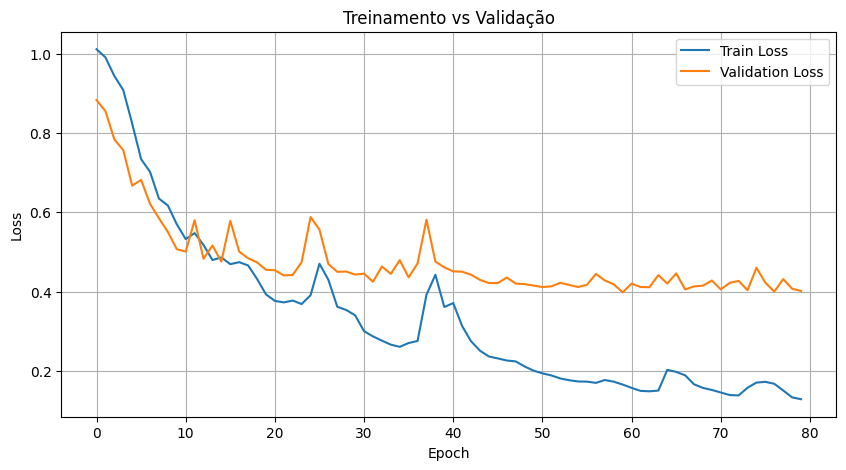

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Treinamento vs Validação")
plt.legend()
plt.grid(True)
plt.show()

In [79]:
epoch_losses

[1.0108703672885895,
 0.9904457852244377,
 0.9434838518500328,
 0.9080360382795334,
 0.8235732614994049,
 0.7340426743030548,
 0.7022000551223755,
 0.6346962004899979,
 0.6173848770558834,
 0.5701664388179779,
 0.532632440328598,
 0.5477000847458839,
 0.5179843381047249,
 0.4800059422850609,
 0.4865381084382534,
 0.46955060958862305,
 0.4744843877851963,
 0.4662858806550503,
 0.43235403299331665,
 0.39356887340545654,
 0.3770718574523926,
 0.37323226034641266,
 0.37786390632390976,
 0.36901507899165154,
 0.3912883847951889,
 0.4705921933054924,
 0.43006300181150436,
 0.36212921887636185,
 0.35420524701476097,
 0.3407415896654129,
 0.3008401021361351,
 0.2876325510442257,
 0.2769713941961527,
 0.2668359652161598,
 0.26135935448110104,
 0.27090103551745415,
 0.27609865739941597,
 0.3925646096467972,
 0.442794106900692,
 0.3616691753268242,
 0.37154390662908554,
 0.3134816326200962,
 0.27528901025652885,
 0.25157343596220016,
 0.23695917800068855,
 0.23217123560607433,
 0.2268838193267583

In [80]:
val_losses


[0.8826269209384918,
 0.85502490401268,
 0.7837094962596893,
 0.7567725777626038,
 0.6672661006450653,
 0.681797593832016,
 0.6215009838342667,
 0.5852652341127396,
 0.5506480485200882,
 0.5072399824857712,
 0.5012520849704742,
 0.5801603198051453,
 0.48316922783851624,
 0.5165647268295288,
 0.4759412407875061,
 0.5786144435405731,
 0.5012864470481873,
 0.48424816131591797,
 0.47402694821357727,
 0.45538096129894257,
 0.4542216658592224,
 0.44115884602069855,
 0.44236017763614655,
 0.47458767890930176,
 0.5882284045219421,
 0.5565321296453476,
 0.46974073350429535,
 0.45026178658008575,
 0.45092910528182983,
 0.44322624802589417,
 0.44571779668331146,
 0.4252236634492874,
 0.46374037861824036,
 0.4451000839471817,
 0.4797205179929733,
 0.4362725466489792,
 0.471397340297699,
 0.5814773589372635,
 0.4758947193622589,
 0.46162669360637665,
 0.45139846205711365,
 0.45060014724731445,
 0.44294315576553345,
 0.42990879714488983,
 0.4221159666776657,
 0.4219522923231125,
 0.435974657535553,


In [81]:
# class InferenceHelper:
#     def __init__(self, vggt_model, dpt_head, device="cuda", dtype=torch.float32, img_size=(518, 518)):
#         """
#         Initializes the InferenceHelper.

#         Args:
#             vggt_model (torch.nn.Module): The trained VGGT backbone model.
#             dpt_head (torch.nn.Module): The trained DPTHead model.
#             device (str or torch.device): The device to run inference on.
#             dtype (torch.dtype): The data type for model inputs.
#             img_size (tuple): The target size for input images (height, width).
#         """
#         self.vggt_model = vggt_model.to(device).eval() # Ensure model is on device and in eval mode
#         self.dpt_head = dpt_head.to(device).eval()   # Ensure head is on device and in eval mode
#         self.device = device
#         self.dtype = dtype
#         self.img_size = img_size

#     def preprocess_image(self, image_path):
#         """
#         Loads and preprocesses a single GeoTIFF image for inference.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Preprocessed image tensor, or None if an error occurs.
#         """
#         try:
#             with rasterio.open(image_path) as src:
#                 image_data = src.read() # Shape (bands, height, width)

#                 # Convert to torch tensor and handle dtype
#                 image_tensor = torch.from_numpy(image_data).to(self.device, dtype=self.dtype)

#                 # Handle channel order/count if necessary (assuming model expects 3 channels)
#                 if image_tensor.shape[0] == 4:
#                     # Assuming RGBA, take RGB
#                     image_tensor = image_tensor[:3, :, :]
#                 elif image_tensor.shape[0] == 1:
#                      # Assuming grayscale, repeat channel
#                      image_tensor = image_tensor.repeat(3, 1, 1)
#                 elif image_tensor.shape[0] != 3:
#                     print(f"Warning: Input image has {image_tensor.shape[0]} bands. Expected 1, 3, or 4. Attempting to use first 3 if available.")
#                     if image_tensor.shape[0] >= 3:
#                          image_tensor = image_tensor[:3, :, :]
#                     else:
#                          print("Error: Cannot get 3 bands from input image. Skipping.")
#                          return None


#                 # Resize if necessary (assuming model expects IMG_SIZE)
#                 if image_tensor.shape[1:] != self.img_size:
#                      print(f"Resizing image from {image_tensor.shape[1:]} to {self.img_size}")
#                      # Add batch and channel dim for interpolation, then remove batch dim
#                      image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=self.img_size, mode='bilinear', align_corners=False).squeeze(0)


#                 # Add batch dimension for model input
#                 image_tensor = image_tensor.unsqueeze(0) # Shape [1, C, H, W]


#                 return image_tensor.to(self.device, dtype=self.dtype) # Ensure final dtype is correct

#         except Exception as e:
#             print(f"Error loading or preprocessing image {image_path}: {e}")
#             return None


#     def predict(self, image_path):
#         """
#         Performs inference on a single image.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Predicted height map tensor, or None if an error occurs.
#         """
#         input_tensor = self.preprocess_image(image_path)

#         if input_tensor is None:
#             return None

#         with torch.no_grad():
#             # Add sequence dimension [1, S=1, C, H, W]
#             images_seq = input_tensor.unsqueeze(1)
#             tokens_list, patch_start_idx = self.vggt_model.aggregator(images_seq)
#             predicted_height_batch, _ = self.dpt_head(tokens_list, images_seq, patch_start_idx)

#             # Select the first sample from the batch and remove the sequence dimension
#             predicted_height = predicted_height_batch[:, 0].squeeze(0)

#         return predicted_height.squeeze(0) # Return shape [H, W]


#     def predict_and_visualize(self, image_path):
#         """
#         Performs inference and visualizes the predicted height map.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.
#         """
#         predicted_height_tensor = self.predict(image_path)

#         if predicted_height_tensor is not None:
#             # Move to CPU and convert to NumPy for visualization
#             predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

#             # Visualize the predicted height map
#             plt.figure(figsize=(6, 6))
#             plt.imshow(predicted_height_np, cmap='viridis')
#             plt.title(f"Predicted Height Map for {os.path.basename(image_path)}")
#             plt.colorbar(label='Predicted Height Value')
#             plt.axis('off')
#             plt.show()
#         else:
#             print(f"Could not generate prediction for {image_path}")

In [82]:
# # CHANGED: InferenceHelper with load_and_preprocess_geotiff

# class InferenceHelper:
#     def __init__(self, vggt_model, dpt_head, device="cuda", dtype=torch.float32, img_size=(518, 518)):
#         """
#         Inizializza l'InferenceHelper.

#         Args:
#             vggt_model (torch.nn.Module): Il modello backbone VGGT allenato.
#             dpt_head (torch.nn.Module): L'head DPT allenato.
#             device (str or torch.device): Il dispositivo su cui eseguire l'inferenza.
#             dtype (torch.dtype): Il tipo di dato per gli input del modello.
#             img_size (tuple): La dimensione target per le immagini di input (altezza, larghezza).
#         """
#         # Ensure models are on the correct device and in evaluation mode
#         self.vggt_model = vggt_model.to(device).eval()
#         self.dpt_head = dpt_head.to(device).eval()
#         self.device = device
#         self.dtype = dtype
#         self.img_size = img_size

#     def preprocess_image(self, image_path):
#         """
#         Loads and preprocesses a single GeoTIFF image for inference using
#         the project's load_and_preprocess_geotiff function.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Preprocessed image tensor [1, C, H, W], or None if an error occurs.
#         """
#         try:
#             # Use the existing utility function to load and preprocess
#             # Assumes load_and_preprocess_geotiff returns a tensor with shape [B, C, H, W]
#             # or similar, and handles normalization and initial resizing/cropping.
#             # We wrap image_path in a list as load_and_preprocess_geotiff expects a list.
#             image_tensor, _ = load_and_preprocess_geotiff([image_path], mode="crop", target_size=self.img_size)

#             if image_tensor is None:
#                  print(f"load_and_preprocess_geotiff returned None for {image_path}")
#                  return None

#             # load_and_preprocess_geotiff likely returns [B=1, C, H, W] for a single path input
#             # Ensure it's on the correct device and dtype, although the utility might handle this
#             image_tensor = image_tensor.to(self.device, dtype=self.dtype)

#             # Add batch dimension if not already present (utility might return [C, H, W]?)
#             # Based on RemoteSensingHeightDataset usage, it seems to return [B, C, H, W]
#             # If it returns [C, H, W], uncomment the line below:
#             # image_tensor = image_tensor.unsqueeze(0) # Shape [1, C, H, W]

#             # Check the final shape before returning
#             if image_tensor.ndim != 4 or image_tensor.shape[0] != 1 or image_tensor.shape[2:] != self.img_size:
#                  print(f"Warning: Unexpected tensor shape after loading/preprocessing: {image_tensor.shape}")
#                  # Attempt to fix common issues if possible, or raise error/return None
#                  if image_tensor.ndim == 3 and image_tensor.shape[1:] == self.img_size:
#                      print("Assuming shape is [C, H, W], adding batch dimension.")
#                      image_tensor = image_tensor.unsqueeze(0)
#                  elif image_tensor.ndim == 4 and image_tensor.shape[0] == 1:
#                       print(f"Assuming shape is [1, C, H, W], but spatial dims {image_tensor.shape[2:]} != {self.img_size}. Attempting resize.")
#                       image_tensor = F.interpolate(image_tensor, size=self.img_size, mode='bilinear', align_corners=False)
#                  else:
#                      print("Shape cannot be easily corrected. Returning None.")
#                      return None


#             return image_tensor

#         except Exception as e:
#             print(f"Error loading or preprocessing image {image_path} with utility function: {e}")
#             return None


#     def predict(self, image_path):
#         """
#         Performs inference on a single image.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Predicted height map tensor [H, W], or None if an error occurs.
#         """
#         input_tensor = self.preprocess_image(image_path)

#         if input_tensor is None:
#             return None

#         with torch.no_grad():
#             # Add sequence dimension [1, S=1, C, H, W]
#             # input_tensor is already [1, C, H, W] from preprocess_image
#             images_seq = input_tensor.unsqueeze(1)

#             # Pass through VGGT aggregator
#             tokens_list, patch_start_idx = self.vggt_model.aggregator(images_seq)

#             # Pass through DPT Head
#             predicted_output_batch, _ = self.dpt_head(tokens_list, images_seq, patch_start_idx) # predicted_output_batch shape is likely [B, S, output_dim, H', W']

#             # Select the first sample from the batch (since B=1)
#             # Select the first sequence element (since S=1)
#             # Select the first output channel (assuming height is the first output)
#             predicted_height_tensor = predicted_output_batch[:, 0, 0, :, :] # Shape [B, H', W'], where B=1

#             # Remove the batch dimension
#             predicted_height_tensor = predicted_height_tensor.squeeze(0) # Shape [H', W']

#             # Note: The output size (H', W') might be different from input size (H, W)
#             # depending on the DPTHead's architecture and the down_ratio.
#             # If your target output needs to be the same size as the input IMG_SIZE,
#             # you might need an F.interpolate step here if it's not handled by the head.
#             # Assuming the head outputs the correct size or close enough for now.


#         return predicted_height_tensor


#     def predict_and_visualize(self, image_path):
#         """
#         Performs inference and visualizes the predicted height map.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.
#         """
#         predicted_height_tensor = self.predict(image_path)

#         if predicted_height_tensor is not None:
#             # Move to CPU and convert to NumPy for visualization
#             predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

#             # Visualize the predicted height map
#             plt.figure(figsize=(6, 6))
#             plt.imshow(predicted_height_np, cmap='viridis')
#             plt.title(f"Predicted Height Map for {os.path.basename(image_path)}")
#             plt.colorbar(label='Predicted Height Value')
#             plt.axis('off')
#             plt.show()
#         else:
#             print(f"Could not generate prediction for {os.path.basename(image_path)}")

In [83]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
# Supondo que load_and_preprocess_geotiff está definida em algum lugar
# from your_utils import load_and_preprocess_geotiff

class InferenceHelper:
    # 1. ADICIONE mds_mean e mds_std AO CONSTRUTOR
    def __init__(self, vggt_model, dpt_head, mds_mean, mds_std, device="cuda", dtype=torch.float32, img_size=(518, 518)):
        """
        Inicializa o InferenceHelper.

        Args:
            vggt_model (torch.nn.Module): O modelo backbone VGGT treinado.
            dpt_head (torch.nn.Module): O head DPT treinado.
            mds_mean (torch.Tensor): A média global para desnormalização.
            mds_std (torch.Tensor): O desvio padrão global para desnormalização.
            device (str or torch.device): O dispositivo para a inferência.
            dtype (torch.dtype): O tipo de dado para os inputs.
            img_size (tuple): O tamanho alvo para as imagens.
        """
        self.vggt_model = vggt_model.to(device).eval()
        self.dpt_head = dpt_head.to(device).eval()
        self.device = device
        self.dtype = dtype
        self.img_size = img_size

        # Armazena as estatísticas de desnormalização
        self.mds_mean = mds_mean.to(device)
        self.mds_std = mds_std.to(device)

    def preprocess_image(self, image_path):
        """
        Carrega e pré-processa uma única imagem GeoTIFF para inferência.
        """
        try:
            image_tensor, _ = load_and_preprocess_geotiff([image_path], mode="crop", target_size=self.img_size)

            if image_tensor is None:
                print(f"load_and_preprocess_geotiff retornou None para {image_path}")
                return None

            image_tensor = image_tensor.to(self.device, dtype=self.dtype)

            if image_tensor.ndim != 4 or image_tensor.shape[0] != 1:
                print(f"Warning: Shape inesperada após pré-processamento: {image_tensor.shape}")
                return None

            return image_tensor

        except Exception as e:
            print(f"Erro ao carregar ou pré-processar a imagem {image_path}: {e}")
            return None

    def predict(self, image_path):
        """
        Executa a inferência e desnormaliza o resultado.
        """
        input_tensor = self.preprocess_image(image_path)

        if input_tensor is None:
            return None

        with torch.no_grad():
            images_seq = input_tensor.unsqueeze(1)
            tokens_list, patch_start_idx = self.vggt_model.aggregator(images_seq)
            predicted_output_batch, _ = self.dpt_head(tokens_list, images_seq, patch_start_idx)

            # Predição normalizada [B, H', W'], com B=1
            predicted_normalized = predicted_output_batch[:, 0, 0, :, :]

            # APLIQUE A DESNORMALIZAÇÃO AQUI
            # Operação inversa: (pred * std) + mean
            predicted_denormalized = predicted_normalized * self.mds_std + self.mds_mean

            # Garante que a profundidade não seja negativa
            predicted_denormalized = torch.clamp(predicted_denormalized, min=0)

            # Remove a dimensão do batch para retornar [H', W']
            predicted_final = predicted_denormalized.squeeze(0)

        return predicted_final

    def predict_and_visualize(self, image_path):
        """
        Executa a inferência e visualiza o mapa de altura predito e desnormalizado.
        """
        predicted_height_tensor = self.predict(image_path)

        if predicted_height_tensor is not None:
            predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

            plt.figure(figsize=(6, 6))
            plt.imshow(predicted_height_np, cmap='viridis')
            plt.title(f"Predicted Height Map for {os.path.basename(image_path)}")
            # O colorbar agora mostrará os valores na escala correta (desnormalizados)
            plt.colorbar(label='Predicted Height Value (denormalized)')
            plt.axis('off')
            plt.show()
        else:
            print(f"Não foi possível gerar a predição para {os.path.basename(image_path)}")

In [84]:
# Example usage (assuming vggt_model and dpt_head are already trained and available)
# Replace 'path/to/your/test_image.tif' with the actual path to a test image

# Initialize the inference helper
# inference_helper = InferenceHelper(vggt_model, dpt_head, device=device, dtype=dtype, img_size=IMG_SIZE)

# Predict and visualize for a test image
# test_image_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/aa_test_input_data_all/tile_7770_7770.tif" # Replace with a valid path
# inference_helper.predict_and_visualize(test_image_path)

In [85]:
stats_file_path = 'mds_normalization_stats_build.txt' # Path where you saved the stats
loaded_mean = None
loaded_std = None

if os.path.exists(stats_file_path):
    try:
        with open(stats_file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('mean:'):
                    loaded_mean = float(line.split(':')[1])
                elif line.startswith('std:'):
                    loaded_std = float(line.split(':')[1])
        print(f"Loaded global normalization statistics: mean={loaded_mean}, std={loaded_std}")
    except IOError as e:
        print(f"Error loading normalization statistics: {e}")
    except ValueError:
        print(f"Error parsing normalization statistics file: {stats_file_path}")
else:
    raise FileNotFoundError(f"Normalization statistics file not found at {stats_file_path}. Cannot perform unnormalization.")

if loaded_mean is None or loaded_std is None:
    raise ValueError("Could not load both mean and standard deviation from the stats file.")

# Convert loaded values to tensors and move to device for unnormalization function if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_mds_mean_tensor = torch.tensor(loaded_mean).to(device)
global_mds_std_tensor = torch.tensor(loaded_std).to(device)

Loaded global normalization statistics: mean=7.049096584320068, std=12.111794471740723


In [87]:
# Define the paths for inference data
inference_input_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/aa_inference_data_input"
inference_reference_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/aa_inference_data_reference"

# List the inference input and reference files
inference_image_list = sorted([os.path.join(inference_input_path, f) for f in os.listdir(inference_input_path) if f.endswith(".tif") or f.endswith(".tiff")])
inference_reference_list = sorted([os.path.join(inference_reference_path, f) for f in os.listdir(inference_reference_path) if f.endswith(".tif") or f.endswith(".tiff")])

print(f"Found {len(inference_image_list)} inference input images.")
print(f"Found {len(inference_reference_list)} inference reference images.")

# Ensure the number of input and reference files match
if len(inference_image_list) != len(inference_reference_list):
    raise ValueError("The number of inference input and reference files do not match.")

Found 2 inference input images.
Found 2 inference reference images.


In [88]:
# # Initialize the inference helper
# # Assuming vggt_model and dpt_head are already trained and available in the environment
# inference_helper = InferenceHelper(vggt_model, dpt_head, device=device, dtype=dtype, img_size=IMG_SIZE)

# print("InferenceHelper instantiated.")

In [89]:
# Initialize the inference helper
# Assuming vggt_model and dpt_head are already trained and available in the environment
inference_helper = InferenceHelper(
    vggt_model=vggt_model,
    dpt_head=dpt_head,
    mds_mean=global_mds_mean_tensor,    # ✅ Passando a média carregada
    mds_std=global_mds_std_tensor,      # ✅ Passando o desvio padrão carregado
    device=device,
    dtype=dtype,
    img_size=IMG_SIZE
)

print("InferenceHelper instanciado com as estatísticas de desnormalização.")

InferenceHelper instanciado com as estatísticas de desnormalização.



Generating predictions and visualizations for inference data...

Processing tile_518_1036.tif...
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/aa_inference_data_input/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
  MAE: 5.9525
  RMSE: 11.2639


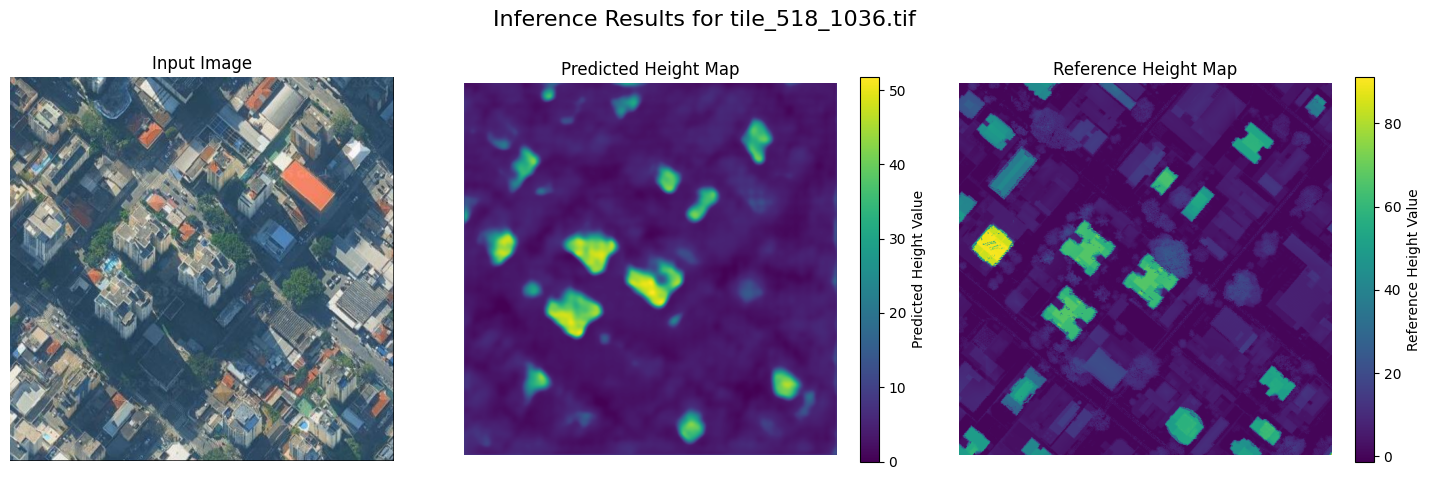


Processing tile_518_518.tif...
Escalando imagem /content/drive/MyDrive/Colab Notebooks/vggt/input_data/aa_inference_data_input/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
  MAE: 7.1017
  RMSE: 13.1123


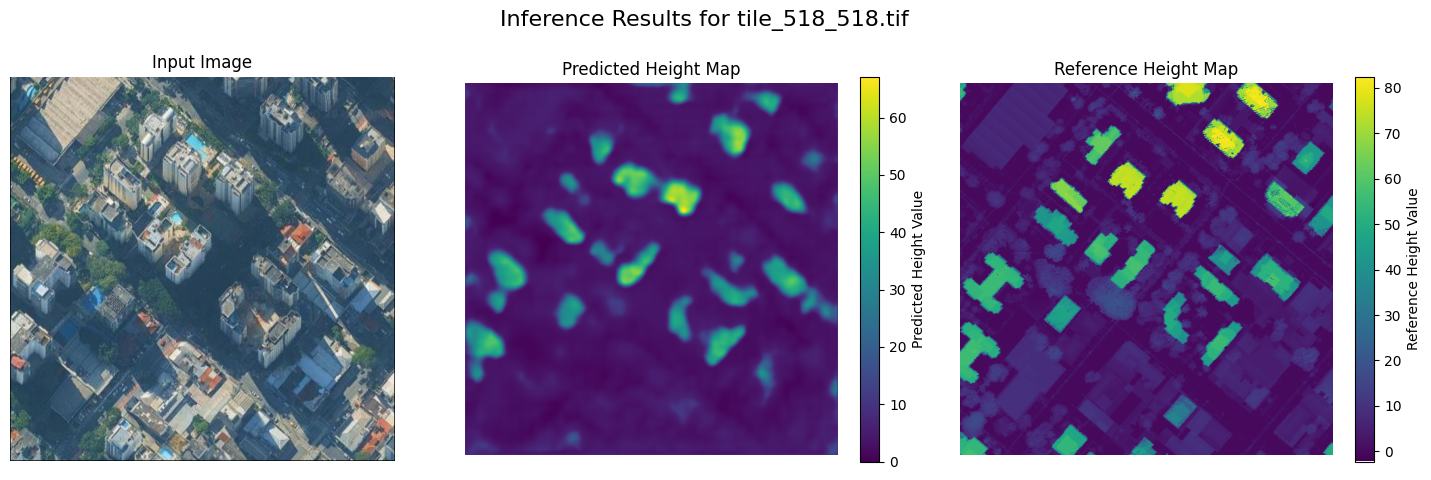


--- Overall Inference Metrics ---
Average MAE over 2 images: 6.5271
Average RMSE over 2 images: 12.1881

Inference and visualization complete.


In [90]:
# Iterate through the inference images, predict, and visualize
print("\nGenerating predictions and visualizations for inference data...")

# Visualize a limited number of inference results to avoid overwhelming output
max_visualizations = 10

# Initialize lists to store metrics for aggregation
mae_scores = []
rmse_scores = []

for i, image_path in enumerate(inference_image_list):
    if i >= max_visualizations:
        print(f"Displayed {max_visualizations} inference results. Stopping visualization.")
        break

    reference_path = inference_reference_list[i] # Assuming sorted lists match

    print(f"\nProcessing {os.path.basename(image_path)}...")

    # Predict the height map
    predicted_height_tensor = inference_helper.predict(image_path)

    if predicted_height_tensor is not None:
        try:
            # Load the input image for visualization
            with rasterio.open(image_path) as src:
                input_image_data = src.read()
                input_image_np = input_image_data.transpose(1, 2, 0) # Transpose to (H, W, C)
                if input_image_np.shape[-1] == 4: # Handle RGBA
                    input_image_np = input_image_np[:, :, :3]
                elif input_image_np.shape[-1] == 1: # Handle grayscale
                     input_image_np = input_image_np.squeeze(-1)

            # Load the reference height map
            with rasterio.open(reference_path) as src:
                reference_height_data = src.read(1) # Read the single band
                reference_height_np = reference_height_data

            # Convert predicted height to NumPy
            predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

            # --- Calculate Metrics ---
            # Ensure both arrays have the same shape
            if predicted_height_np.shape != reference_height_np.shape:
                print(f"Warning: Predicted and reference shapes do not match for {os.path.basename(image_path)}. Skipping metric calculation.")
                # Proceed with visualization if possible, but skip metrics
            else:
                # Calculate Mean Absolute Error (MAE)
                mae = np.mean(np.abs(predicted_height_np - reference_height_np))
                mae_scores.append(mae)
                print(f"  MAE: {mae:.4f}")

                # Calculate Root Mean Squared Error (RMSE)
                rmse = np.sqrt(np.mean((predicted_height_np - reference_height_np)**2))
                rmse_scores.append(rmse)
                print(f"  RMSE: {rmse:.4f}")

            # Visualize Input, Predicted, and Reference
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f"Inference Results for {os.path.basename(image_path)}", fontsize=16)

            # Input Image
            axes[0].imshow(input_image_np, cmap='gray' if input_image_np.ndim == 2 else None) # Use gray cmap for grayscale
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # Predicted Height Map
            im1 = axes[1].imshow(predicted_height_np, cmap='viridis')
            axes[1].set_title("Predicted Height Map")
            axes[1].axis('off')
            fig.colorbar(im1, ax=axes[1], label='Predicted Height Value')

            # Reference Height Map
            im2 = axes[2].imshow(reference_height_np, cmap='viridis')
            axes[2].set_title("Reference Height Map")
            axes[2].axis('off')
            fig.colorbar(im2, ax=axes[2], label='Reference Height Value')


            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show()

        except Exception as e:
            print(f"Error visualizing or calculating metrics for {os.path.basename(image_path)}: {e}")

    else:
        print(f"Skipping visualization and metric calculation for {os.path.basename(image_path)} due to prediction error.")

# --- Aggregate and Print Overall Metrics ---
print("\n--- Overall Inference Metrics ---")
if mae_scores: # Check if any metrics were calculated
    overall_mae = np.mean(mae_scores)
    overall_rmse = np.mean(rmse_scores)
    print(f"Average MAE over {len(mae_scores)} images: {overall_mae:.4f}")
    print(f"Average RMSE over {len(rmse_scores)} images: {overall_rmse:.4f}")
else:
    print("No metrics were calculated (e.g., no successful predictions or shape mismatches).")


print("\nInference and visualization complete.")